In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os

In [2]:

BATCH_SIZE = 16
# VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.1
NUM_EPOCHS = 50

# Constants
FRAME_HEIGHT = 224
FRAME_WIDTH = 224
SEQUENCE_LENGTH = 30

ARCHITECTURE = '2D_CNN_LSTM'
CNN_TYPE = 'Resnet'
LSTM_HIDDEN_SIZE=512
LSTM_LAYERS = 1
DROPOUT = 0.5
LEARNING_RATE = 0.001

In [3]:
# Mount Google Drive
from google.colab import drive
import os

drive.mount('/content/gdrive')
# Define base folder path
base_path = '/content/gdrive/MyDrive/RGB_data_stream'
!ls /content/gdrive/MyDrive/RGB_data_stream/
# base_path = '../'

Mounted at /content/gdrive
1DCNNLSTM_Cross_fold
2DCNNLSTM-Jan28
complete_pre_processed
CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet
data
gaussian_blur_aug
horz_aug
mobile_net_nov2
new_save
nov10_bi_lstm
nov10_equal_interval_sample
nov11_bi_lstm
nov11_Second_bi_lstm
nov12_unknown_attention
nov16_unknown_attention
nov7_equal_interval_sample
nov9_equal_interval_sample
pre_processed_short
resize_aug
RESIZED_SHORTS
Resnet_nov6
save
SECOND_mobile_net_nov2
Second_Resnet_nov6
short
SMPLer-X
SMPLR-X
VIBE
Without_augmentation_1DCNNLSTM_Cross_fold


In [4]:
import os

# Gets label
csv_path = os.path.join(base_path,'data/3DYoga90_corrected.csv')
meta_info_path = os.path.join(base_path, 'data')
# Gets valid samples
sequence_path = os.path.join(base_path, 'short/downloaded_log.txt')
corrupted_path = os.path.join(base_path, 'short/corrupted_log.txt')

# Original Downloaded Seqeuence
video_dir = os.path.join(base_path, 'short')

# Pre_processed to tensor to make training fast # Makes video_dir redundant BUT NOT WITH KAGGLE IDK
preprocessed_dir = os.path.join(base_path, 'RESIZED_SHORTS')
os.makedirs(preprocessed_dir, exist_ok=True)
assert os.path.isdir(preprocessed_dir), f"Directory '{preprocessed_dir}' does not exist."

In [5]:
file_path = os.path.join(video_dir, "missing_videos_log.txt")

# Count lines in the file
with open(file_path, "r", encoding="utf-8") as f:
    line_count = sum(1 for _ in f)

print(f"Number of lines in missing_videos.txt: {line_count}")

Number of lines in missing_videos.txt: 303


In [6]:
file_path = os.path.join(video_dir, "downloaded_log.txt")

# Count lines in the file
with open(file_path, "r", encoding="utf-8") as f:
    line_count = sum(1 for _ in f)

print(f"Number of lines in missing_videos.txt: {line_count}")

Number of lines in missing_videos.txt: 1944


In [7]:
import os
from datetime import datetime

today = datetime.today().strftime('%Y-%m-%d')
SAVE_PATH = os.path.join(
    base_path,
    f'CROSS_FOLD_{ARCHITECTURE}_{today}_LR{LEARNING_RATE}_LHS{LSTM_HIDDEN_SIZE}_LL{LSTM_LAYERS}_CT{CNN_TYPE}'
)
os.makedirs(SAVE_PATH, exist_ok=True)
print(SAVE_PATH)

pose_list = ['downward-dog','standing-forward-bend','half-way-lift',
            #  'mountain','chair','cobra','cockerel','extended-triangle',
            #  'extended-side-angle','corpse','staff','wind-relieving','fish'
            ]
pose_list = ['downward-dog','standing-forward-bend','half-way-lift','mountain']
            #  'extended-side-angle','corpse','staff','wind-relieving','fish'
            # ]

subset_of_poses = pose_list
NUM_CLASSES = len(pose_list)

# dataset_dir = os.path.join(base_path, 'official_dataset')
# assert os.path.isdir(dataset_dir), f"Directory '{dataset_dir}' does not exist."


/content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet


In [8]:
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

2.5.1+cu124


In [9]:
# meta_info_path = os.path.join(base_path, 'data')
# pose_index = pd.read_csv(f'{meta_info_path}/pose-index.csv')
# sequence_index = pd.read_csv(f'{meta_info_path}/3DYoga90_corrected.csv')

What does each file tell?

1.) pose-index.csv -> Shows Heirarchical organization (THEN NOTHING MORE)

2.) 3DYoga90.csv -> Total Main Info(i.e. along with RGB stream){
    SequneceID: Parquet_FILE_NAME,
    URL,
    Frame Start and Frame Stop,
    Pose Name, Training Test Split
} `Difference between train and test? where to get the validation set from? How to do data augmentation?

3.) Parquet Files -> {
    Frame Number {
        33 Landmarks
    },
    row-id: FrameNumber-TYPE-Landmark_index,
    Coordinates: {x, y, z}
}

`PLEASE NOTE: The landmark coordinates are all normalized`

# Getting the data ready

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms.v2 as T
import random

class VideoAugmentationPipeline:
    """Video augmentation pipeline using batch transforms from torchvision.transforms.v2"""
    def __init__(self, spatial_aug_config=None, temporal_aug_config=None):
        # Default config with all augmentations enabled
        default_spatial_config = {
            'random_resized_crop': {'enabled': False, 'scale': (0.9, 1.0)},
            'random_horizontal_flip': {'enabled': True, 'p': 0.5},
            'color_jitter': {'enabled': True, 'brightness': 0.1, 'contrast': 0.1, 'saturation': 0.1, 'p': 0.5},
            'gaussian_blur': {'enabled': True, 'p': 0.5},
            'random_rotation': {'enabled': True, 'degrees': (-5, 5),'p':0.5},
        }

        default_temporal_config = {
            'temporal_crop': {'enabled': True, 'crop_size': 0.9},
            'temporal_mask': {'enabled': True, 'n_masks': 1, 'mask_size': 0.1},
        }

        # Update default config with user-provided config
        self.spatial_aug_config = self._update_config(default_spatial_config, spatial_aug_config)
        self.temporal_aug_config = self._update_config(default_temporal_config, temporal_aug_config)

        # Build transforms that can handle batch inputs
        self.spatial_transforms = self._build_spatial_transforms()

    def _update_config(self, default_config, user_config):
        """Update default config with user config, disabling augmentations not in user config"""
        if user_config is None:
            return default_config

        updated_config = default_config.copy()
        for aug_name in updated_config:
            if aug_name in user_config:
                # # Update probability if provided
                # if isinstance(user_config[aug_name], dict):
                #     updated_config[aug_name].update(user_config[aug_name])
                # else:
                    updated_config[aug_name]['p'] = user_config[aug_name]
            else:
                # Disable augmentation if not in user config
                updated_config[aug_name]['enabled'] = False
        return updated_config

    def _build_spatial_transforms(self):
        """Build composition of spatial transforms that support batch processing"""
        transform_list = []

        if self.spatial_aug_config['random_resized_crop']['enabled']:
            transform_list.append(
                T.RandomResizedCrop(
                    size=(224, 224),
                    scale=self.spatial_aug_config['random_resized_crop']['scale'],
                    antialias=True
                )
            )

        if self.spatial_aug_config['random_horizontal_flip']['enabled']:
            transform_list.append(
                T.RandomHorizontalFlip(p=self.spatial_aug_config['random_horizontal_flip']['p'])
            )

        if self.spatial_aug_config['color_jitter']['enabled']:
            transform_list.append(
                T.ColorJitter(
                    brightness=self.spatial_aug_config['color_jitter']['brightness'],
                    contrast=self.spatial_aug_config['color_jitter']['contrast'],
                    saturation=self.spatial_aug_config['color_jitter']['saturation']
                )
            )

        if self.spatial_aug_config['gaussian_blur']['enabled']:
            transform_list.append(
                T.GaussianBlur(
                    kernel_size=(5, 5),
                    sigma=(0.1, 1.0)
                )
            )

        if self.spatial_aug_config['random_rotation']['enabled']:
            if random.random() < self.spatial_aug_config['random_rotation']['p']:
                transform_list.append(
                    T.RandomRotation(
                        degrees=self.spatial_aug_config['random_rotation']['degrees'],
                        interpolation=T.InterpolationMode.BILINEAR
                    )
                )

        return T.Compose(transform_list)

    def apply_temporal_augmentation(self, video_tensor):
        """Apply temporal augmentations to video tensor"""
        if not any(cfg['enabled'] for cfg in self.temporal_aug_config.values()):
            return video_tensor

        T, C, H, W = video_tensor.shape

        # Temporal crop
        if self.temporal_aug_config['temporal_crop']['enabled']:
            crop_size = int(T * self.temporal_aug_config['temporal_crop']['crop_size'])
            start_idx = random.randint(0, T - crop_size)
            video_tensor = video_tensor[start_idx:start_idx + crop_size]

        # Temporal masking
        if self.temporal_aug_config['temporal_mask']['enabled']:
            T = len(video_tensor)
            mask_size = int(T * self.temporal_aug_config['temporal_mask']['mask_size'])
            for _ in range(self.temporal_aug_config['temporal_mask']['n_masks']):
                if random.random() < 0.5:
                    start_idx = random.randint(0, T - mask_size)
                    video_tensor[start_idx:start_idx + mask_size] = 0

        return video_tensor

    def __call__(self, video_tensor):
        """Apply transforms to entire video tensor at once"""
        # Input shape: [T, C, H, W]
        # Reshape to [T, C, H, W] -> [1, T, C, H, W] for batch processing
        video_tensor = video_tensor.unsqueeze(0)

        # Apply spatial transforms to entire video tensor at once
        # transforms.v2 will maintain temporal consistency automatically
        video_tensor = self.spatial_transforms(video_tensor)

        # Remove batch dimension
        video_tensor = video_tensor.squeeze(0)

        # Apply temporal augmentations
        # video_tensor = self.apply_temporal_augmentation(video_tensor)

        return video_tensor

In [11]:
import os
import torch
import pandas as pd
import numpy as np
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import imageio
import random

class YogaVideoDataset(Dataset):
    def __init__(self, csv_path, sequence_path, pose_list, video_dir, preprocessed_dir,
                 spatial_aug_config=None, temporal_aug_config=None, use_augmentation=True, aug_ratio = 0.5):
        with open(sequence_path) as f:
            sequence_list = f.read().splitlines()
            sequence_list = [int(x) for x in sequence_list]

        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df['sequence_id'].isin(sequence_list)]
        self.df = self.df[self.df['l3_pose'].isin(pose_list)]

        self.pose_to_label = {pose: idx for idx, pose in enumerate(pose_list)}
        self.length_of_dataset = len(self.df)

        self.video_dir = video_dir
        self.preprocessed_dir = preprocessed_dir
        os.makedirs(self.preprocessed_dir, exist_ok=True)

        # Initialize augmentation pipeline
        self.augmentation_pipeline = VideoAugmentationPipeline(
            spatial_aug_config=spatial_aug_config,
            temporal_aug_config=temporal_aug_config
        )

        self.cache = dict()
        self.augmentation_ratio = aug_ratio
        self.use_augmentation = use_augmentation

        self.transforms = transforms.Compose([
            transforms.Resize((FRAME_HEIGHT, FRAME_WIDTH)),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                      std=[0.229, 0.224, 0.225])
        ])
        self.normalization = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    def __len__(self):
        return self.length_of_dataset

    def __getitem__(self, i):
        sequence_id = self.df.iloc[i]['sequence_id']
        pose = self.df.iloc[i]['l3_pose']
        label = self.pose_to_label[pose]

        # Load preprocessed frames
        if sequence_id in self.cache:
            frames = self.cache[sequence_id]
        else:
            file_path = os.path.join(self.preprocessed_dir, f"{sequence_id}.pt")
            if not os.path.exists(file_path):
                video_path = os.path.join(self.video_dir, f"{sequence_id}.mp4")
                frames = self._get_frames(video_path)
                torch.save(frames, file_path)
            else:
                frames = torch.load(file_path, weights_only=True)
            # self.cache[sequence_id] = frames

        # Choose whether to use augmented or original data
        use_augmented_data = self.use_augmentation and self.augmentation_ratio < random.random()
        if use_augmented_data:
            frames = self.augmentation_pipeline(frames)

        frames = self.normalization(frames)
        return frames, label

    # def _get_frames(self, video_path, sequence_length = SEQUENCE_LENGTH):
    #     reader = imageio.get_reader(video_path, 'ffmpeg')
    #     fps = imageio.get_reader(video_path, 'ffmpeg').get_meta_data()['fps'] // 1
    #     total_frames = reader.count_frames()
    #     print(f"Processing video: {video_path}")
    #     print(f"Video FPS: {fps}")
    #     indices = np.arange(0, fps - 1, fps // SEQUENCE_LENGTH, dtype=int)

    #     # print(indices)
    #     frames = []
    #     for i, frame in enumerate(reader):
    #         if i % fps in indices:
    #             frame = Image.fromarray(frame)
    #             frame = self.transforms(frame)
    #             frames.append(frame)
    #             # print('Frame number', i % fps, 'Frame', i)

    #     reader.close()
    #     # print('Frame Length', len(frames))
    #     frames = torch.stack(frames)
    #     return frames
    # def _get_frames(self, video_path, sequence_length = SEQUENCE_LENGTH):
    #     reader = imageio.get_reader(video_path, 'ffmpeg')
    #     fps = imageio.get_reader(video_path, 'ffmpeg').get_meta_data()['fps'] // 1
    #     total_frames = reader.count_frames()

    #     print(f"Processing video: {video_path}")
    #     print(f"Total frames: {total_frames}")

    #     # Calculate frame indices to sample
    #     step = max(1, total_frames // sequence_length)
    #     indices = np.linspace(0, total_frames - 1, num=sequence_length, dtype=int)

    #     frames = []
    #     for i, frame in enumerate(reader):
    #         if i in indices:
    #             frame = Image.fromarray(frame)
    #             frame = self.transforms(frame)
    #             frames.append(frame)
    #             # print('Frame number', i % fps, 'Frame', i)

    #     reader.close()
    #     print('Frame Length', len(frames))
    #     frames = torch.stack(frames)
    #     return frames
    def _get_frames(self, video_path, sequence_length=SEQUENCE_LENGTH, corrupted_log_path = corrupted_path):
        reader = imageio.get_reader(video_path, 'ffmpeg')
        fps = imageio.get_reader(video_path, 'ffmpeg').get_meta_data()['fps'] // 1
        total_frames = reader.count_frames()



        # Calculate frame indices to sample
        indices = np.linspace(0, total_frames - 1, num=sequence_length, dtype=int)
        t_indices =[]
        frames = []
        for i, frame in enumerate(reader):
            if i in indices:
                frame = Image.fromarray(frame)
                frame = self.transforms(frame)
                frames.append(frame)
                t_indices.append(i)
                # print('Frame number', i % fps, 'Frame', i)

        reader.close()

        # If extracted frames do not match sequence_length, log to corrupted_log_path
        if len(frames) != sequence_length:
            with open(corrupted_log_path, "a") as f:
                f.write(f"Corrupted video: {video_path}\n")
                f.write(f"Expected {sequence_length} frames, got {len(frames)}\n")
                f.write(f"Selected frame indices: {t_indices}\n\n")
            print(f"Processing video: {video_path}")
            print(f"Total frames: {total_frames}")
            print(f"Total frames: {t_indices}")
            print(f"Final frame count: {len(frames)}")


        # Ensure frames tensor has correct shape
        if frames:
            frames = torch.stack(frames)
        else:
            frames = torch.empty(0)  # Return an empty tensor if no frames are found

        return frames

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils

class AttentionLayer(nn.Module):
    """Basic attention mechanism for sequence processing"""
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.W = nn.Linear(input_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output, mask=None):
        att_scores = self.V(torch.tanh(self.W(lstm_output))).squeeze(-1)

        if mask is not None:
            att_scores = att_scores.masked_fill(mask == 0, -1e9)

        att_weights = F.softmax(att_scores, dim=1)
        context = (lstm_output * att_weights.unsqueeze(-1)).sum(1)
        return context, att_weights

class CNNLSTM(nn.Module):
    """Modular video action classifier with various configuration options"""
    def __init__(self, num_classes,
                 lstm_hidden_size=512,
                 lstm_layers=1,
                 dropout=0.5,
                 freeze_cnn=True,
                 use_attention=False,
                 cnn_model='resnet18'):

        super().__init__()
        self.cnn_feature_size = 512  # Default for ResNet18
        self.use_attention = use_attention

        # CNN Feature Extractor
        self.cnn, self.cnn_feature_size = self._build_cnn(cnn_model)
        self._set_cnn_freeze(freeze_cnn)

        # Sequence Processing
        self.lstm = nn.LSTM(
            input_size=self.cnn_feature_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_layers,
            batch_first=True,
            # bidirectional=True,
            dropout=dropout if lstm_layers > 1 else 0
        )

        # Attention Mechanism
        if self.use_attention:
            self.attention = AttentionLayer(
                input_size=lstm_hidden_size*2,
                hidden_size=lstm_hidden_size
            )

        # Classification Head
        self.classifier = self._build_classifier(
            lstm_hidden_size*1,
            num_classes,
            dropout
        )

        # Initialize weights
        self._initialize_weights()

    def _build_cnn(self, model_name):
        """Initialize CNN feature extractor"""
        if model_name == 'resnet18':
            cnn = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
            return nn.Sequential(*list(cnn.children())[:-2]), 512  # Remove avgpool and fc
        else:
            raise ValueError(f"Unsupported CNN model: {model_name}")

    def _build_classifier(self, input_size, num_classes, dropout):
        """Build modular classification head"""
        return nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout/2),

            nn.Linear(128, num_classes)
        )

    def _initialize_weights(self):
        """Initialize weights for classification layers"""
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _set_cnn_freeze(self, freeze):
        """Freeze/unfreeze CNN parameters"""
        for param in self.cnn.parameters():
            param.requires_grad = not freeze

    def forward(self, x, lengths):
        # Process frames through CNN
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size*seq_len, *x.size()[2:])
        x = self.cnn(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(batch_size, seq_len, -1)

        # Process sequence through LSTM
        packed_x = rnn_utils.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.lstm(packed_x)
        lstm_out, _ = rnn_utils.pad_packed_sequence(packed_out, batch_first=True)

        # Get final representation
        if self.use_attention:
            mask = self._create_attention_mask(lstm_out.size(1), lengths)
            context, _ = self.attention(lstm_out, mask)
        else:
            # Get last valid time step output
            context = lstm_out[torch.arange(batch_size), lengths-1, :]

        return self.classifier(context)

    def _create_attention_mask(self, max_len, lengths):
        """Create attention mask from sequence lengths"""
        device = lengths.device
        return torch.arange(max_len, device=device).expand(len(lengths), max_len) < lengths.unsqueeze(1)

    def unfreeze_cnn_layers(self, num_layers=3, start_from_end=True):
        """Gradually unfreeze CNN layers for fine-tuning"""
        conv_layers = [m for m in self.cnn.modules() if isinstance(m, nn.Conv2d)]
        num_total = len(conv_layers)

        if start_from_end:
            layers_to_unfreeze = conv_layers[-num_layers:]
        else:
            layers_to_unfreeze = conv_layers[:num_layers]

        for layer in layers_to_unfreeze:
            for param in layer.parameters():
                param.requires_grad = True

    def count_parameters(self):
        total_params = 0
        for name, parameter in self.named_parameters():
            if parameter.requires_grad:
                params = parameter.numel()
                print(f"{name}: {params}")
                total_params += params
        print(f"Total Trainable Params: {total_params}")

In [13]:
import os
import torch
def save_checkpoint(model, optimizer, epoch, history, save_path = SAVE_PATH, best_path=None):
    if best_path is not None:
        chk_path = os.path.join(save_path, f'best_model.pth')
        print(f"Saving checkpoint to {chk_path}")
    else:
        chk_path = os.path.join(save_path, f'checkpath_model.pth')
        print(f"Saving checkpoint to {chk_path}")

    # Combine model, optimizer, and history into one dictionary
    checkpoint = {
        'epoch': epoch + 1,  # Save the next epoch number for resuming
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history  # Save history along with the model and optimizer
    }

    # Save everything in a single file using torch.save
    torch.save(checkpoint, chk_path)
    print(f"Checkpoint saved at epoch {epoch + 1}")

In [14]:
def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Load model and training state from a checkpoint
    """
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, weights_only = False)

    # Load model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Get the epoch number to resume from
    start_epoch = checkpoint['epoch']

    # Load training history with new metrics
    history = checkpoint.get('history', {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rates': []
    })

    return model, optimizer, start_epoch, history


In [15]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        # on default = 7 successive val_loss increase stop
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score
import os
import matplotlib.pyplot as plt

def plot_per_class_metric(precision, recall, f1, epoch=0, pose_list=None, master_save_path=SAVE_PATH):
    """
    Plots and saves per-class metrics (Precision, Recall, F1-score) for the given epoch.

    Args:
        precision (list): Per-class precision values.
        recall (list): Per-class recall values.
        f1 (list): Per-class F1-score values.
        epoch (int): Current epoch number.
        pose_list (list): List of class names (strings) corresponding to class indices.
        master_save_path (str): Directory to save the plot.
    """
    if pose_list is None:
        pose_list = [str(i) for i in range(len(precision))]  # Default to numeric labels

    save_dir = os.path.join(master_save_path, 'per_class_metric')
    os.makedirs(save_dir, exist_ok=True)

    save_file_path = os.path.join(save_dir, f'per_class_metric_epoch_{epoch}.png')

    # Adjust x-axis positions for grouped bars
    x = range(len(pose_list))

    plt.bar([i - 0.2 for i in x], precision, width=0.2, label='Precision', align='center')
    plt.bar(x, recall, width=0.2, label='Recall', align='center')
    plt.bar([i + 0.2 for i in x], f1, width=0.2, label='F1-Score', align='center')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title(f'Per-Class Metrics - Epoch {epoch}')
    plt.xticks(x, pose_list, rotation=45, ha='right')  # Use pose_list for x-axis labels
    plt.legend()
    plt.tight_layout()  # Adjust layout to fit rotated labels
    plt.savefig(save_file_path)
    plt.show()

def per_class_metric(true, pred, epoch, pose_list=pose_list, average=None):
    """
    Computes and logs per-class metrics (Precision, Recall, F1-score).

    Args:
        true (list): Ground-truth labels.
        pred (list): Predicted labels.
        epoch (int): Current epoch number.
        pose_list (list): List of class names (strings) corresponding to class indices.
        average (str or None): Averaging method for sklearn metrics (None for per-class).
    """
    per_class_precision = precision_score(true, pred, average=average, zero_division=0)
    per_class_recall = recall_score(true, pred, average=average, zero_division=0)
    per_class_f1 = f1_score(true, pred, average=average, zero_division=0)

    print(f"Per-Class Metrics for Epoch {epoch}:")
    for i, (prec, rec, f1) in enumerate(zip(per_class_precision, per_class_recall, per_class_f1)):
        class_name = pose_list[i] if pose_list else f"Class {i}"
        print(f"{class_name}: Precision={prec:.2f}, Recall={rec:.2f}, F1-Score={f1:.2f}")

    plot_per_class_metric(per_class_precision, per_class_recall, per_class_f1, epoch, pose_list)


In [17]:
import os
import torch
from torch.optim import lr_scheduler
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, dataset,fold, num_epochs=50, patience=18, log_interval=10, checkpoint_path=None, unfreeze_epoch=5, num_layers_unfreeze=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print("Using device:", device)

    # Initialize scheduler
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)

    start_epoch = 0
    best_val_loss = float('inf')

    # Initialize history for loss, accuracy, precision, recall, and F1
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_precision': [], 'train_recall': [], 'train_f1': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'learning_rates': []
    }

    # Check for checkpoint and load if available
    if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(model, optimizer, checkpoint_path)
        print(f"Resuming training from epoch {start_epoch}")
        torch.cuda.empty_cache()

    for epoch in range(start_epoch, num_epochs):
        dataset.use_augmentation = True #############
        print(f'\nEpoch {epoch + 1}/{num_epochs}')

        current_lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(current_lr)
        print(f"Current Learning Rate: {current_lr}")

        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        train_true, train_pred = [], []

        train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (inputs, labels, lengths) in train_loader_tqdm:
            inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # Collect true and predicted labels for precision/recall
            train_true.extend(labels.cpu().numpy())
            train_pred.extend(predicted.cpu().numpy())

            # Log batch-level updates
            if batch_idx % log_interval == 0:
                train_loader_tqdm.set_postfix({
                    'loss': train_loss / (BATCH_SIZE * (batch_idx + 1)),
                    'accuracy': 100.0 * train_correct / train_total
                })

        # Calculate training metrics
        train_loss /= len(train_loader.dataset)
        train_acc = 100.0 * train_correct / train_total
        train_precision = precision_score(train_true, train_pred, average='macro')
        train_recall = recall_score(train_true, train_pred, average='macro')
        train_f1 = f1_score(train_true, train_pred, average='macro')

        per_class_metric(train_true, train_pred, epoch)

        dataset.use_augmentation = False
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_true, val_pred = [], []

        val_loader_tqdm = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation")
        with torch.no_grad():
            for batch_idx, (inputs, labels, lengths) in val_loader_tqdm:
                inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)
                outputs = model(inputs, lengths)  # Pass sequence lengths to model forward function
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # Collect true and predicted labels for precision/recall
                val_true.extend(labels.cpu().numpy())
                val_pred.extend(predicted.cpu().numpy())

                # Log batch-level updates for validation
                if batch_idx % log_interval == 0:
                    val_loader_tqdm.set_postfix({
                        'loss': val_loss / (BATCH_SIZE * (batch_idx + 1)),
                        'accuracy': 100.0 * val_correct / val_total
                    })

        # Calculate validation metrics
        val_loss /= len(val_loader.dataset)
        val_acc = 100.0 * val_correct / val_total
        val_precision = precision_score(val_true, val_pred, average='macro')
        val_recall = recall_score(val_true, val_pred, average='macro')
        val_f1 = f1_score(val_true, val_pred, average='macro')
        # Per-class metrics for validation
        per_class_metric(val_true, val_pred, epoch)
        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1'].append(train_f1)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        # Print metrics at the end of the epoch
        print(f'\nEpoch {epoch + 1}/{num_epochs} Summary:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Train Precision: {train_precision:.2f} | Train Recall: {train_recall:.2f} | Train F1: {train_f1:.2f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val Precision: {val_precision:.2f} | Val Recall: {val_recall:.2f} | Val F1: {val_f1:.2f}')

        # Save the best model checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(SAVE_PATH, f'best_model_fold_{fold}.pth')
            if best_model_path is not None:
                print(best_model_path)
            save_checkpoint(model, optimizer, epoch, history, SAVE_PATH, best_model_path)
            print(f"New best model saved! Validation Loss: {best_val_loss:.4f}")

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

        # Check for early stopping
        # early_stopping(val_loss)
        # if early_stopping.early_stop:
        #     print("Early stopping triggered")
        #     break

    return model, history

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import torch
import numpy as np
import os
from tqdm import tqdm

def evaluate_model(model, test_loader, criterion, class_names, spath=SAVE_PATH, fsave='confusion_matrix.png'):
    """
    Evaluate model on test set

    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        criterion: Loss function
        class_names: List of class names
        spath: Directory to save the plot
        fsave: Filename for confusion matrix plot

    Returns:
        test_loss: Average test loss
        accuracy: Test accuracy
        precision: Macro precision score
        recall: Macro recall score
        f1: Macro F1 score
    """
    csave = os.path.join(spath, fsave)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []

    test_loader_tqdm = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for inputs, labels, lengths in test_loader_tqdm:
            inputs = inputs.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)
            outputs = model(inputs, lengths)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * test_correct / test_total

    # Calculate metrics with macro averaging
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')

    cm = confusion_matrix(all_labels, all_predictions)
   # Create figure with adjusted size and subplot positioning
    plt.figure(figsize=(12, 10))  # Increased figure size
    plt.subplot(111, position=[0.1, 0.2, 0.8, 0.7])  # Adjust main plot position to leave room for text

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Prepare metrics text
    metrics_text = (f'Test Loss: {test_loss:.4f}\n'
                    f'Test Accuracy: {accuracy:.2f}%\n'
                    f'Precision (Macro): {precision:.4f}\n'
                    f'Recall (Macro): {recall:.4f}\n'
                    f'F1 Score (Macro): {f1:.4f}')

    # Add metrics text with adjusted position
    plt.gcf().text(0, 0.02, metrics_text, fontsize=12, ha='left', va='bottom')

    # Adjust layout to prevent cutting off
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Leave space at bottom for metrics

    # Save with tight layout to include all elements
    plt.savefig(csave, bbox_inches='tight')
    plt.show()
    plt.close()

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Precision (Macro): {precision:.4f}')
    print(f'Recall (Macro): {recall:.4f}')
    print(f'F1 Score (Macro): {f1:.4f}')

    return test_loss, accuracy, precision, recall, f1

In [19]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    frames, labels = zip(*batch)  # Separate frames and labels
    # FRAMES == DATA same thing shape (N, T, C, H, W)
    # Pad the sequences of frames for each video in the batch along the sequence dimension
    frames_padded = pad_sequence(frames, batch_first=True, padding_value=0)  # Shape: [batch_size, max_seq_len, 3, 224, 224]
    lengths = torch.tensor([len(seq) for seq in frames])  # Record original sequence lengths

    labels = torch.tensor(labels)

    return frames_padded, labels, lengths  # Return lengths for packing

In [20]:
from torch.utils.data import random_split, DataLoader

def train_test_split(dataset, test_split = TEST_SPLIT):
    total_size = len(dataset)
    test_size = int(test_split * total_size)
    train_size = total_size - test_size

    train_dataset, test_dataset = random_split(
        dataset,
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    return train_dataset, test_dataset

def create_data_loaders(train_dataset, test_dataset, batch_size = BATCH_SIZE):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        collate_fn=collate_fn
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        collate_fn=collate_fn
    )

    return train_loader, test_loader

In [21]:

def plot_training_curves(history, fold):
    fsave=f'training_curves_fold_{fold}.png'
    tsave = os.path.join(SAVE_PATH, fsave)
    # plt.style.use('seaborn')
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Loss curves
    axs[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axs[0, 0].plot(history['val_loss'], label='Validation Loss', marker='o')
    axs[0, 0].set_title('Loss')
    axs[0, 0].legend()

    # Accuracy curves
    axs[0, 1].plot(history['train_acc'], label='Train Accuracy', marker='o')
    axs[0, 1].plot(history['val_acc'], label='Validation Accuracy', marker='o')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].legend()

    # Learning rate
    axs[0, 2].plot(history['learning_rates'], label='Learning Rate', marker='o')
    axs[0, 2].set_title('Learning Rate')
    axs[0, 2].set_yscale('log')
    axs[0, 2].legend()

    # Precision
    axs[1, 0].plot(history['train_precision'], label='Train Precision', marker='o')
    axs[1, 0].plot(history['val_precision'], label='Validation Precision', marker='o')
    axs[1, 0].set_title('Precision')
    axs[1, 0].legend()

    # Recall
    axs[1, 1].plot(history['train_recall'], label='Train Recall', marker='o')
    axs[1, 1].plot(history['val_recall'], label='Validation Recall', marker='o')
    axs[1, 1].set_title('Recall')
    axs[1, 1].legend()

    # F1 Score
    axs[1, 2].plot(history['train_f1'], label='Train F1', marker='o')
    axs[1, 2].plot(history['val_f1'], label='Validation F1', marker='o')
    axs[1, 2].set_title('F1 Score')
    axs[1, 2].legend()

    for ax in axs.flat:
        ax.set_xlabel('Epoch')
        ax.grid(True)

    plt.tight_layout()
    plt.savefig(tsave)
    plt.show()
    plt.close()


In [22]:
import numpy as np
import torch
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

def get_class_weights(pose_list, num_classes, strategy='balanced'):
    """
    Calculate class weights with proper class index alignment.

    Args:
        pose_list: List of labels/poses in the dataset
        num_classes: Total number of classes
        strategy: Weighting strategy ('balanced', 'inverse', 'effective_samples', 'sqrt_inverse')

    Returns:
        torch.Tensor: Class weights tensor aligned with class indices
    """
    # Count samples per class
    class_counts = Counter(pose_list)
    total_samples = len(pose_list)

    # Initialize weights array with zeros for all possible classes
    weights = np.zeros(num_classes)

    if strategy == 'balanced':
        # Use sklearn's balanced weighting
        unique_classes = sorted(class_counts.keys())
        sklearn_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.array(unique_classes),
            y=pose_list
        )
        # Map weights to correct indices
        for idx, class_label in enumerate(unique_classes):
            weights[class_label] = sklearn_weights[idx]

    elif strategy == 'inverse':
        # Inverse of sample frequency
        for class_label, count in class_counts.items():
            weights[class_label] = total_samples / (num_classes * count)

    elif strategy == 'effective_samples':
        # Effective number of samples weighting
        beta = 0.9999
        for class_label, count in class_counts.items():
            weights[class_label] = (1 - beta) / (1 - beta ** count)

    elif strategy == 'sqrt_inverse':
        # Square root of inverse frequency
        for class_label, count in class_counts.items():
            weights[class_label] = np.sqrt(total_samples / (num_classes * count))

    else:
        raise ValueError(f"Unknown weighting strategy: {strategy}")

    # Convert to tensor and normalize
    weights = torch.FloatTensor(weights)
    weights = weights / weights.sum() * len(weights)

    return weights

def create_weighted_criterion(pose_list, num_classes, strategy='balanced'):
    """
    Create a weighted CrossEntropyLoss criterion.

    Args:
        pose_list: List of labels/poses in the dataset
        num_classes: Total number of classes
        strategy: Weighting strategy for calculating class weights

    Returns:
        nn.CrossEntropyLoss: Weighted loss criterion
    """
    weights = get_class_weights(pose_list, num_classes, strategy)
    print("Class weights aligned with indices:", weights)
    if torch.cuda.is_available():
        weights = weights.cuda()
    return nn.CrossEntropyLoss(weight=weights)

def analyze_class_distribution(pose_list):
    """
    Analyze and print class distribution information.

    Args:
        pose_list: List of labels/poses in the dataset
    """
    class_counts = Counter(pose_list)
    total_samples = len(pose_list)

    print("\nClass Distribution Analysis:")
    print("-" * 50)
    for class_idx, count in sorted(class_counts.items()):
        percentage = (count / total_samples) * 100
        print(f"Class {class_idx}: {count} samples ({percentage:.2f}%)")

    # Calculate imbalance metrics
    max_count = max(class_counts.values())
    min_count = min(class_counts.values())
    imbalance_ratio = max_count / min_count

    print("\nImbalance Statistics:")
    print(f"Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
    print(f"Maximum class size: {max_count}")
    print(f"Minimum class size: {min_count}")
    print(f"Average class size: {total_samples/len(class_counts):.2f}")

In [23]:
from torch.utils.data import Subset

def create_data_loaders(train_idx, val_idx, dataset, batch_size=BATCH_SIZE):
    # Create subsets for this fold
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    # Create data loaders with optional collate_fn
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
        collate_fn=collate_fn
    )

    return train_loader, val_loader


In [24]:
def compute_average_history(histories):
    """
    Compute the average history across multiple folds.

    Args:
        histories (list of dict): List of history dictionaries from all folds. Each dictionary contains
                                  metrics like 'train_loss', 'val_loss', 'train_accuracy', etc., as lists.

    Returns:
        dict: Averaged history containing the same keys as the input histories.
    """
    avg_history = {}
    num_folds = len(histories)

    for key in histories[0]:  # Iterate over metric names
        # Initialize a list for each metric
        avg_history[key] = [0.0] * len(histories[0][key])  # Assume all folds have same length histories

        # Sum across all folds
        for fold_history in histories:
            for i, value in enumerate(fold_history[key]):
                avg_history[key][i] += value

        # Divide by the number of folds to compute the average
        avg_history[key] = [val / num_folds for val in avg_history[key]]

    return avg_history

In [25]:
import os
import pickle
from sklearn.model_selection import StratifiedKFold

def save_folds(meta_info_path, skf, folds, architecture=ARCHITECTURE):
    if architecture == '2D_CNN_LSTM':
        folds_path = os.path.join(meta_info_path, f"{architecture}_folds.pkl")
        skf_path = os.path.join(meta_info_path, f"{architecture}_skf.pkl")
    else:
        folds_path = os.path.join(meta_info_path, "folds.pkl")
        skf_path = os.path.join(meta_info_path, "skf.pkl")

    with open(folds_path, "wb") as f:
        pickle.dump(folds, f)

    with open(skf_path, "wb") as f:
        pickle.dump(skf, f)

def load_folds(meta_info_path, architecture=ARCHITECTURE):
    if architecture == '2D_CNN_LSTM':
        folds_path = os.path.join(meta_info_path, f"{architecture}_folds.pkl")
        skf_path = os.path.join(meta_info_path, f"{architecture}_skf.pkl")
    else:
        folds_path = os.path.join(meta_info_path, "folds.pkl")
        skf_path = os.path.join(meta_info_path, "skf.pkl")

    if os.path.exists(folds_path) and os.path.exists(skf_path):
        with open(folds_path, "rb") as f:
            folds = pickle.load(f)
        with open(skf_path, "rb") as f:
            skf = pickle.load(f)
        return skf, folds
    return None, None

In [26]:
import torch
import os
import json
import pickle

def get_weighted_loss_criterion(train_dataset, train_indices=None, meta_info_path=None, fold=None):
    """
    Get or compute weighted loss criterion, with caching support.

    Args:
        train_dataset: The training dataset
        train_indices: Optional indices for cross-validation fold
        meta_info_path: Path to save/load cached criteria
        fold: Current fold number (required if using caching)

    Returns:
        torch.nn.CrossEntropyLoss with computed weights
    """
    if meta_info_path and fold is not None:
        criterion_cache_path = os.path.join(meta_info_path, f'criterion_fold_{fold}.pkl')

        # Try to load cached criterion
        if os.path.exists(criterion_cache_path):
            try:
                with open(criterion_cache_path, 'rb') as f:
                    cached_data = pickle.load(f)

                # Verify the cached criterion matches current data
                if verify_criterion_cache(cached_data, train_indices):
                    print(f"Loading cached criterion for fold {fold}")
                    return cached_data['criterion']
                else:
                    print(f"Cached criterion for fold {fold} is invalid, recomputing...")
            except Exception as e:
                print(f"Error loading cached criterion: {e}, recomputing...")

    # Compute criterion if no cache exists or verification failed
    if train_indices is not None:
        labels = [train_dataset[i][1] for i in train_indices]
    else:
        labels = [train_dataset[i][1] for i in range(len(train_dataset))]

    analyze_class_distribution(labels)
    criterion = create_weighted_criterion(
        labels,
        num_classes=NUM_CLASSES,
        strategy='effective_samples'
    )

    # Cache the computed criterion if path is provided
    if meta_info_path and fold is not None:
        os.makedirs(meta_info_path, exist_ok=True)
        cache_data = {
            'criterion': criterion,
            'train_indices': train_indices,
            'fold': fold
        }
        with open(criterion_cache_path, 'wb') as f:
            pickle.dump(cache_data, f)
        print(f"Cached criterion for fold {fold}")

    return criterion

def verify_criterion_cache(cached_data, current_train_indices):
    """
    Verify that cached criterion matches current training indices.

    Args:
        cached_data: Dictionary containing cached criterion and metadata
        current_train_indices: Current training indices to verify against

    Returns:
        bool: True if cache is valid, False otherwise
    """
    cached_indices = cached_data['train_indices']
    if cached_indices is None and current_train_indices is None:
        return True
    if cached_indices is None or current_train_indices is None:
        return False
    return len(cached_indices) == len(current_train_indices) and all(
        a == b for a, b in zip(sorted(cached_indices), sorted(current_train_indices))
    )

In [29]:
from sklearn.model_selection import StratifiedKFold

def main(lstm_hidden_size= LSTM_HIDDEN_SIZE,lstm_layers = LSTM_LAYERS, num_classes=NUM_CLASSES,LR=LEARNING_RATE, Epochs=50):
    spatial_aug_config = {
        'gaussian_blur': 0.5,
        'random_horizontal_flip':  0.5,
        'color_jitter': 0.5,
        'random_rotation': 0.5
    }

    # temporal_aug_config = {
    #     'temporal_crop': {'enabled': True, 'crop_size': 0.8},
    #     'temporal_mask': {'enabled': True, 'mask_size': 0.2, 'n_masks': 2}
    # }
    dataset, train_dataset, test_dataset = prepare_dataset(spatial_aug_config=spatial_aug_config, temporal_aug_config=None)
    skf, folds = load_folds(meta_info_path, architecture=ARCHITECTURE)

    if folds is None:
        k_folds = 5
        skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
        folds = list(skf.split(np.arange(len(train_dataset)), get_all_the_labels(train_dataset)))
        save_folds(meta_info_path, skf, folds,architecture=ARCHITECTURE)

    best_model = None
    best_val_loss = float('inf')
    best_fold = 0
    all_metrics = []

    print('Starting cross-validation...')

    for fold, (train_idx, val_idx) in enumerate(folds):
        print(f"Fold {fold + 1}/{len(folds)}")
        train_loader, val_loader = create_data_loaders(train_idx, val_idx, train_dataset)

        criterion = get_weighted_loss_criterion(
            train_dataset,
            train_idx,
            meta_info_path=meta_info_path,
            fold=fold
        ).to(device)
        # model = CNNLSTM(in_channels, hidden_channels, num_classes)
        model = CNNLSTM(num_classes=num_classes, lstm_hidden_size=lstm_hidden_size, lstm_layers=lstm_layers, dropout=DROPOUT)
        # optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.01)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.01)

        model, history = train_model(
            model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            dataset,
            fold=fold,
            num_epochs=Epochs,
            patience=10,
            log_interval=1,
            checkpoint_path=None
        )
        plot_training_curves(history, fold)
        all_metrics.append(history)

        if history['val_loss'][-1] < best_val_loss:
            best_val_loss = history['val_loss'][-1]
            best_model = model
            best_fold = fold

    avg_history = compute_average_history(all_metrics)
    plot_training_curves(avg_history, 'average')

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    evaluate_model(best_model, test_loader, criterion, pose_list)

    model_save_path = os.path.join(SAVE_PATH, f'my_model_{best_fold}.pth')
    torch.save(best_model.state_dict(), model_save_path)

def prepare_dataset(spatial_aug_config=None, temporal_aug_config=None):
    dataset = YogaVideoDataset(csv_path, sequence_path, pose_list, video_dir, preprocessed_dir, spatial_aug_config=spatial_aug_config, temporal_aug_config=temporal_aug_config)
    print(len(dataset))
    train_dataset, test_dataset = train_test_split(dataset)
    return dataset,train_dataset,test_dataset

def get_all_the_labels(dataset):
    return [label for _, label in dataset]

692
Starting cross-validation...
Fold 1/5
Loading cached criterion for fold 0
Using device: cuda

Epoch 1/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [09:11<00:00, 17.23s/it, loss=5.39, accuracy=29.7]


Per-Class Metrics for Epoch 0:
downward-dog: Precision=0.38, Recall=0.32, F1-Score=0.34
standing-forward-bend: Precision=0.28, Recall=0.36, F1-Score=0.32
half-way-lift: Precision=0.23, Recall=0.19, F1-Score=0.20
mountain: Precision=0.29, Recall=0.33, F1-Score=0.31


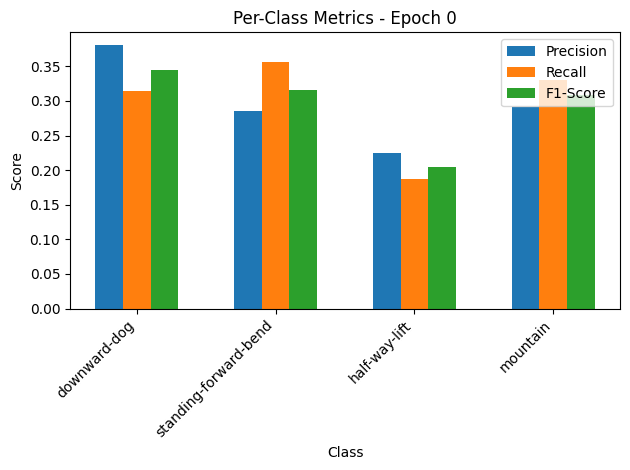

Validation: 100%|██████████| 8/8 [02:13<00:00, 16.65s/it, loss=1.99, accuracy=34.4]


Per-Class Metrics for Epoch 0:
downward-dog: Precision=0.77, Recall=0.27, F1-Score=0.40
standing-forward-bend: Precision=0.29, Recall=0.97, F1-Score=0.45
half-way-lift: Precision=1.00, Recall=0.03, F1-Score=0.06
mountain: Precision=0.00, Recall=0.00, F1-Score=0.00


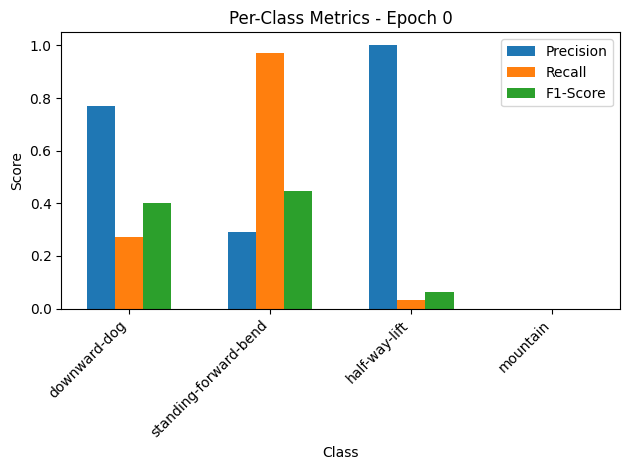


Epoch 1/50 Summary:
Train Loss: 5.5368 | Train Acc: 29.72% | Train Precision: 0.30 | Train Recall: 0.30 | Train F1: 0.29
Val Loss: 2.0424 | Val Acc: 34.40% | Val Precision: 0.52 | Val Recall: 0.32 | Val F1: 0.23
/content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model_fold_0.pth
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model.pth
Checkpoint saved at epoch 1
New best model saved! Validation Loss: 2.0424

Epoch 2/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:23<00:00,  4.47s/it, loss=3.28, accuracy=43.8]


Per-Class Metrics for Epoch 1:
downward-dog: Precision=0.62, Recall=0.49, F1-Score=0.54
standing-forward-bend: Precision=0.38, Recall=0.48, F1-Score=0.42
half-way-lift: Precision=0.37, Recall=0.33, F1-Score=0.35
mountain: Precision=0.41, Recall=0.45, F1-Score=0.43


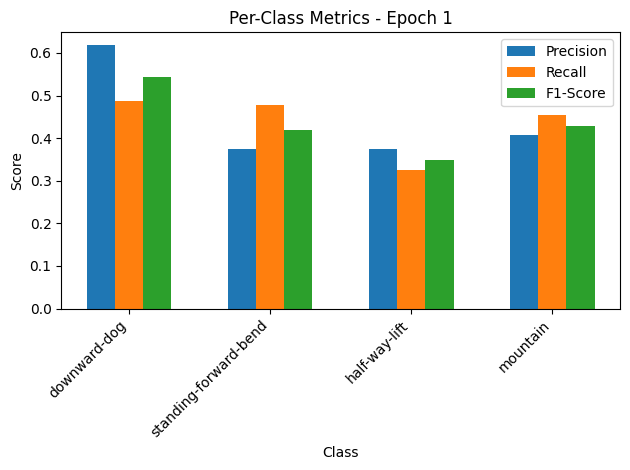

Validation: 100%|██████████| 8/8 [00:19<00:00,  2.40s/it, loss=2.22, accuracy=52.8]


Per-Class Metrics for Epoch 1:
downward-dog: Precision=0.82, Recall=0.62, F1-Score=0.71
standing-forward-bend: Precision=0.39, Recall=0.94, F1-Score=0.55
half-way-lift: Precision=1.00, Recall=0.03, F1-Score=0.06
mountain: Precision=0.65, Recall=0.46, F1-Score=0.54


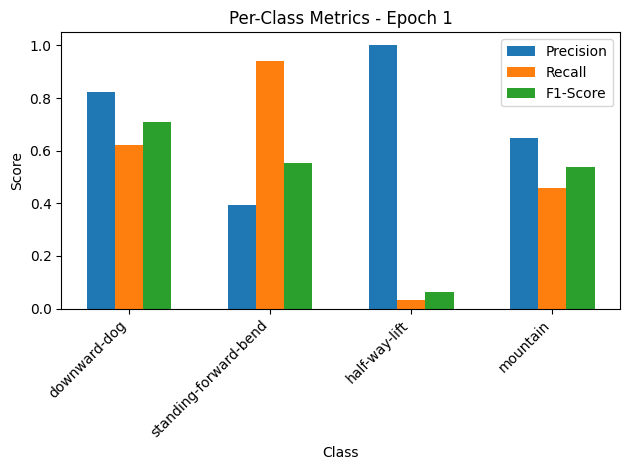


Epoch 2/50 Summary:
Train Loss: 3.3692 | Train Acc: 43.78% | Train Precision: 0.44 | Train Recall: 0.44 | Train F1: 0.44
Val Loss: 2.2703 | Val Acc: 52.80% | Val Precision: 0.72 | Val Recall: 0.51 | Val F1: 0.47

Epoch 3/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:23<00:00,  4.47s/it, loss=3.09, accuracy=47]


Per-Class Metrics for Epoch 2:
downward-dog: Precision=0.65, Recall=0.55, F1-Score=0.59
standing-forward-bend: Precision=0.39, Recall=0.51, F1-Score=0.44
half-way-lift: Precision=0.38, Recall=0.33, F1-Score=0.35
mountain: Precision=0.48, Recall=0.47, F1-Score=0.48


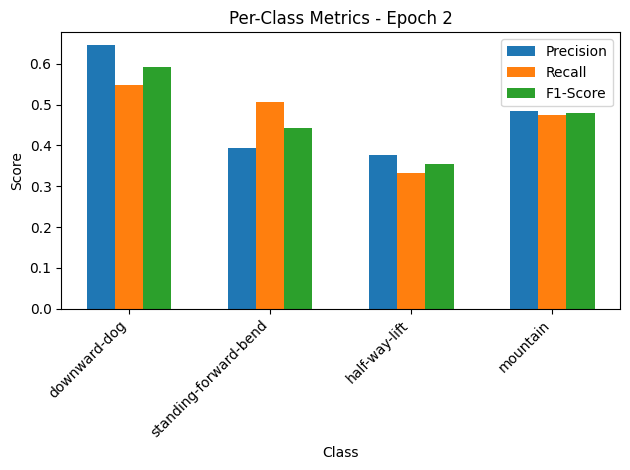

Validation: 100%|██████████| 8/8 [00:18<00:00,  2.34s/it, loss=4.14, accuracy=29.6]


Per-Class Metrics for Epoch 2:
downward-dog: Precision=1.00, Recall=0.27, F1-Score=0.43
standing-forward-bend: Precision=1.00, Recall=0.03, F1-Score=0.06
half-way-lift: Precision=0.67, Recall=0.06, F1-Score=0.12
mountain: Precision=0.22, Recall=1.00, F1-Score=0.36


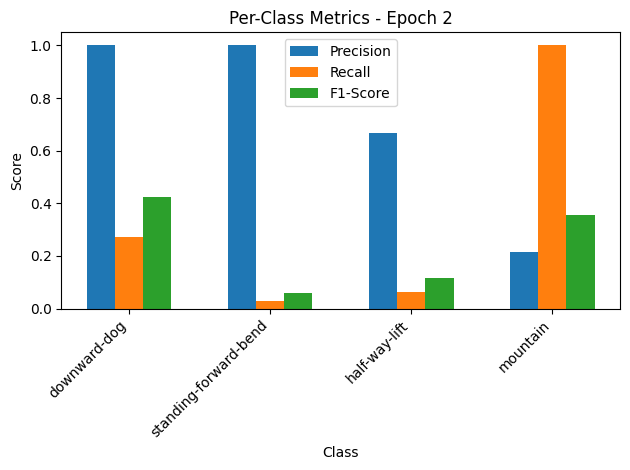


Epoch 3/50 Summary:
Train Loss: 3.1731 | Train Acc: 46.99% | Train Precision: 0.47 | Train Recall: 0.47 | Train F1: 0.47
Val Loss: 4.2386 | Val Acc: 29.60% | Val Precision: 0.72 | Val Recall: 0.34 | Val F1: 0.24

Epoch 4/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:18<00:00,  4.32s/it, loss=2.69, accuracy=51.2]


Per-Class Metrics for Epoch 3:
downward-dog: Precision=0.69, Recall=0.66, F1-Score=0.68
standing-forward-bend: Precision=0.38, Recall=0.39, F1-Score=0.39
half-way-lift: Precision=0.41, Recall=0.37, F1-Score=0.38
mountain: Precision=0.56, Recall=0.63, F1-Score=0.59


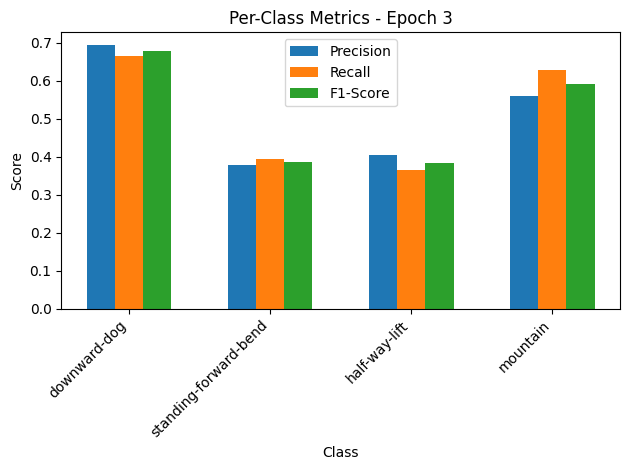

Validation: 100%|██████████| 8/8 [00:18<00:00,  2.33s/it, loss=1.57, accuracy=66.4]


Per-Class Metrics for Epoch 3:
downward-dog: Precision=0.56, Recall=0.95, F1-Score=0.71
standing-forward-bend: Precision=1.00, Recall=0.27, F1-Score=0.43
half-way-lift: Precision=0.64, Recall=0.68, F1-Score=0.66
mountain: Precision=0.86, Recall=0.75, F1-Score=0.80


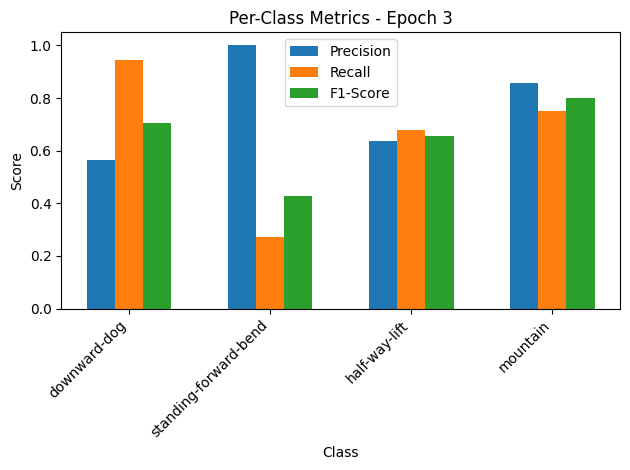


Epoch 4/50 Summary:
Train Loss: 2.7685 | Train Acc: 51.20% | Train Precision: 0.51 | Train Recall: 0.51 | Train F1: 0.51
Val Loss: 1.6036 | Val Acc: 66.40% | Val Precision: 0.76 | Val Recall: 0.66 | Val F1: 0.65
/content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model_fold_0.pth
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model.pth
Checkpoint saved at epoch 4
New best model saved! Validation Loss: 1.6036

Epoch 5/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:28<00:00,  4.64s/it, loss=2.32, accuracy=53]


Per-Class Metrics for Epoch 4:
downward-dog: Precision=0.70, Recall=0.63, F1-Score=0.66
standing-forward-bend: Precision=0.45, Recall=0.46, F1-Score=0.45
half-way-lift: Precision=0.42, Recall=0.37, F1-Score=0.39
mountain: Precision=0.55, Recall=0.67, F1-Score=0.60


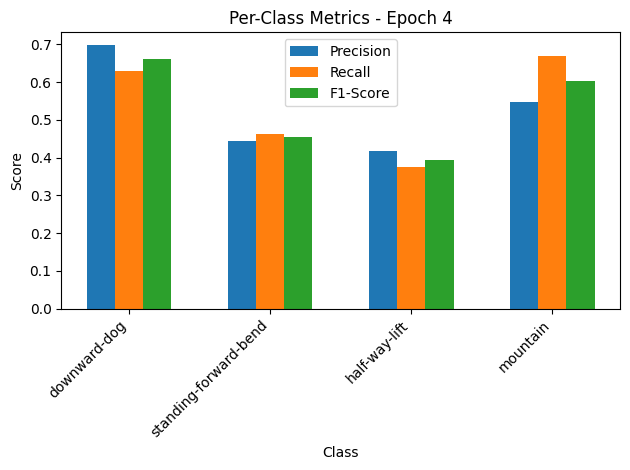

Validation: 100%|██████████| 8/8 [00:19<00:00,  2.45s/it, loss=1.24, accuracy=66.4]


Per-Class Metrics for Epoch 4:
downward-dog: Precision=0.97, Recall=0.76, F1-Score=0.85
standing-forward-bend: Precision=0.92, Recall=0.33, F1-Score=0.49
half-way-lift: Precision=0.43, Recall=0.97, F1-Score=0.60
mountain: Precision=0.93, Recall=0.58, F1-Score=0.72


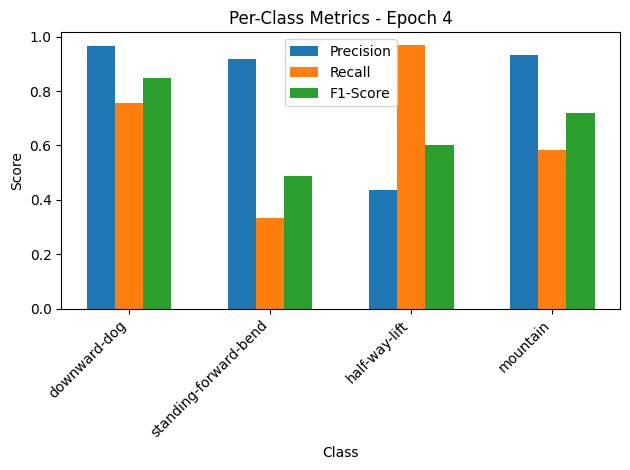


Epoch 5/50 Summary:
Train Loss: 2.3883 | Train Acc: 53.01% | Train Precision: 0.53 | Train Recall: 0.53 | Train F1: 0.53
Val Loss: 1.2735 | Val Acc: 66.40% | Val Precision: 0.81 | Val Recall: 0.66 | Val F1: 0.66
/content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model_fold_0.pth
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model.pth
Checkpoint saved at epoch 5
New best model saved! Validation Loss: 1.2735

Epoch 6/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:22<00:00,  4.46s/it, loss=1.8, accuracy=63.3]


Per-Class Metrics for Epoch 5:
downward-dog: Precision=0.77, Recall=0.75, F1-Score=0.76
standing-forward-bend: Precision=0.54, Recall=0.57, F1-Score=0.55
half-way-lift: Precision=0.56, Recall=0.49, F1-Score=0.52
mountain: Precision=0.64, Recall=0.72, F1-Score=0.68


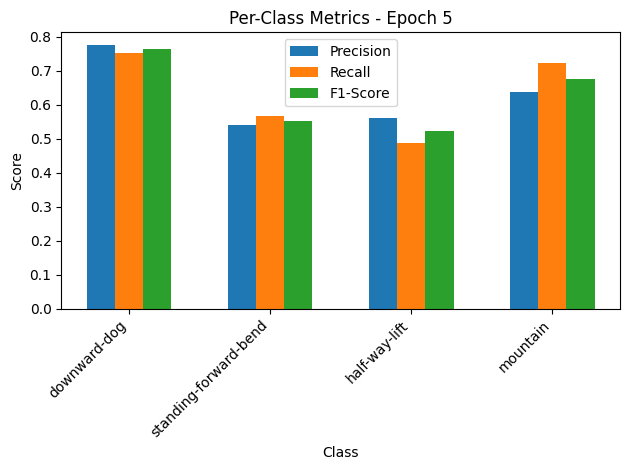

Validation: 100%|██████████| 8/8 [00:19<00:00,  2.46s/it, loss=1.83, accuracy=63.2]


Per-Class Metrics for Epoch 5:
downward-dog: Precision=0.91, Recall=0.78, F1-Score=0.84
standing-forward-bend: Precision=0.62, Recall=0.55, F1-Score=0.58
half-way-lift: Precision=0.50, Recall=0.48, F1-Score=0.49
mountain: Precision=0.50, Recall=0.71, F1-Score=0.59


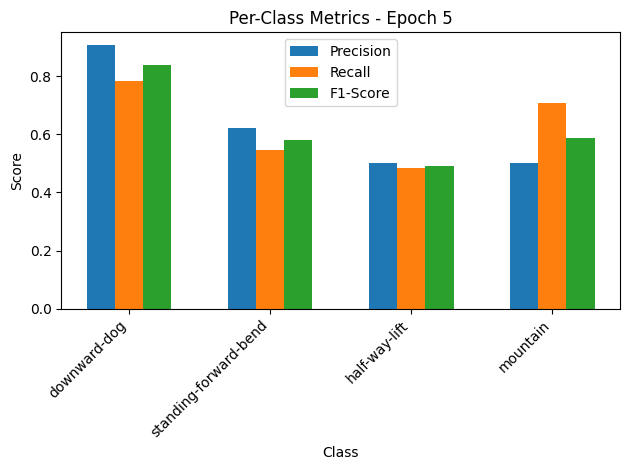


Epoch 6/50 Summary:
Train Loss: 1.8497 | Train Acc: 63.25% | Train Precision: 0.63 | Train Recall: 0.63 | Train F1: 0.63
Val Loss: 1.8691 | Val Acc: 63.20% | Val Precision: 0.63 | Val Recall: 0.63 | Val F1: 0.62

Epoch 7/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:20<00:00,  4.40s/it, loss=1.69, accuracy=60]


Per-Class Metrics for Epoch 6:
downward-dog: Precision=0.76, Recall=0.71, F1-Score=0.73
standing-forward-bend: Precision=0.49, Recall=0.55, F1-Score=0.52
half-way-lift: Precision=0.47, Recall=0.46, F1-Score=0.46
mountain: Precision=0.71, Recall=0.69, F1-Score=0.70


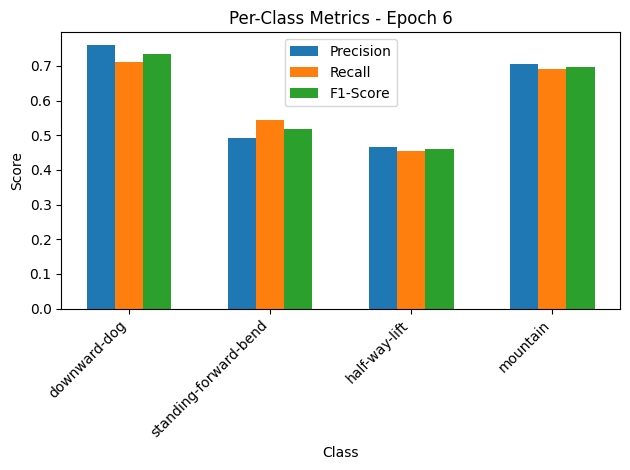

Validation: 100%|██████████| 8/8 [00:19<00:00,  2.49s/it, loss=2.4, accuracy=52]


Per-Class Metrics for Epoch 6:
downward-dog: Precision=1.00, Recall=0.38, F1-Score=0.55
standing-forward-bend: Precision=0.47, Recall=0.27, F1-Score=0.35
half-way-lift: Precision=0.40, Recall=0.61, F1-Score=0.48
mountain: Precision=0.52, Recall=0.96, F1-Score=0.68


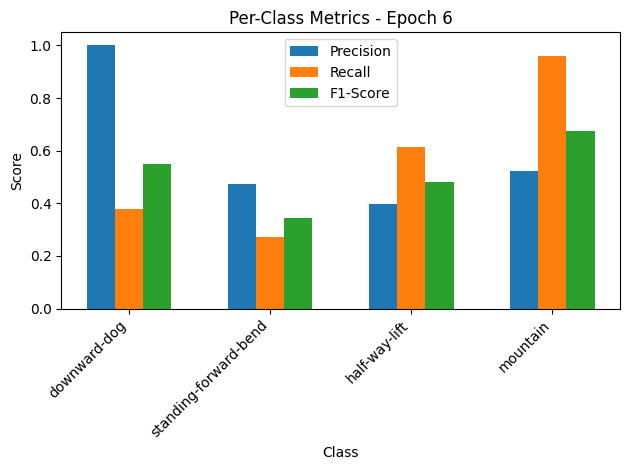


Epoch 7/50 Summary:
Train Loss: 1.7359 | Train Acc: 60.04% | Train Precision: 0.61 | Train Recall: 0.60 | Train F1: 0.60
Val Loss: 2.4539 | Val Acc: 52.00% | Val Precision: 0.60 | Val Recall: 0.56 | Val F1: 0.51

Epoch 8/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:09<00:00,  4.05s/it, loss=1.62, accuracy=60.6]


Per-Class Metrics for Epoch 7:
downward-dog: Precision=0.74, Recall=0.69, F1-Score=0.72
standing-forward-bend: Precision=0.54, Recall=0.57, F1-Score=0.55
half-way-lift: Precision=0.51, Recall=0.47, F1-Score=0.49
mountain: Precision=0.62, Recall=0.70, F1-Score=0.66


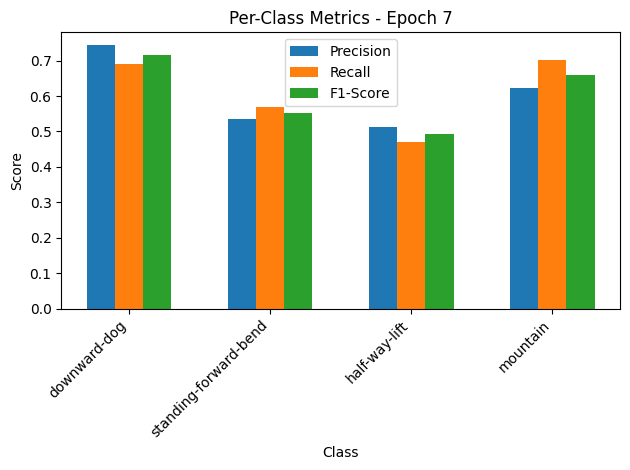

Validation: 100%|██████████| 8/8 [00:19<00:00,  2.45s/it, loss=1.12, accuracy=63.2]


Per-Class Metrics for Epoch 7:
downward-dog: Precision=0.81, Recall=0.81, F1-Score=0.81
standing-forward-bend: Precision=0.51, Recall=0.55, F1-Score=0.53
half-way-lift: Precision=0.48, Recall=0.35, F1-Score=0.41
mountain: Precision=0.67, Recall=0.83, F1-Score=0.74


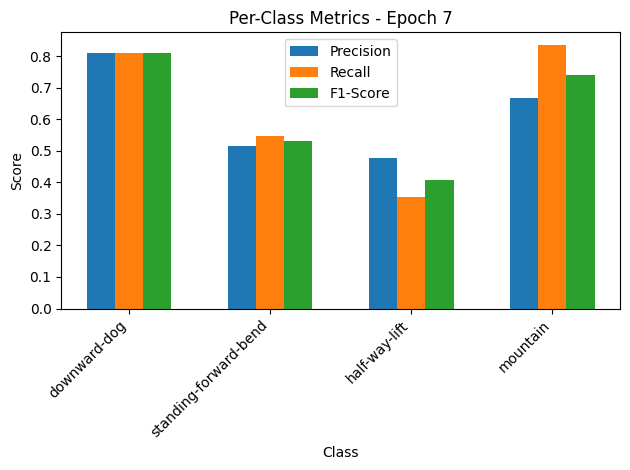


Epoch 8/50 Summary:
Train Loss: 1.6643 | Train Acc: 60.64% | Train Precision: 0.60 | Train Recall: 0.61 | Train F1: 0.60
Val Loss: 1.1420 | Val Acc: 63.20% | Val Precision: 0.62 | Val Recall: 0.64 | Val F1: 0.62
/content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model_fold_0.pth
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model.pth
Checkpoint saved at epoch 8
New best model saved! Validation Loss: 1.1420

Epoch 9/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:24<00:00,  4.50s/it, loss=1.45, accuracy=59.2]


Per-Class Metrics for Epoch 8:
downward-dog: Precision=0.73, Recall=0.68, F1-Score=0.70
standing-forward-bend: Precision=0.50, Recall=0.52, F1-Score=0.51
half-way-lift: Precision=0.47, Recall=0.46, F1-Score=0.47
mountain: Precision=0.68, Recall=0.73, F1-Score=0.71


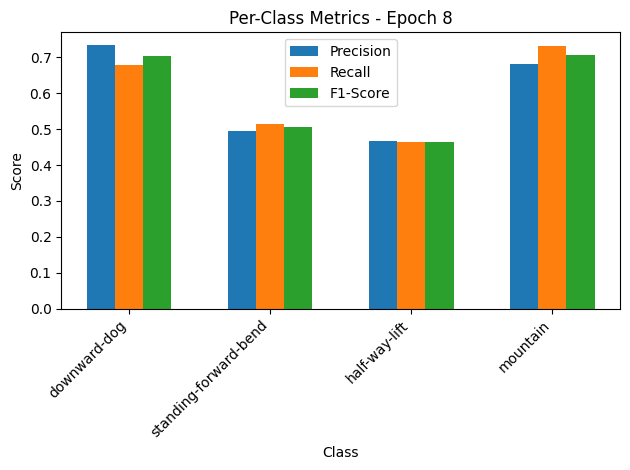

Validation: 100%|██████████| 8/8 [00:19<00:00,  2.43s/it, loss=1.22, accuracy=56.8]


Per-Class Metrics for Epoch 8:
downward-dog: Precision=0.86, Recall=0.68, F1-Score=0.76
standing-forward-bend: Precision=0.44, Recall=0.85, F1-Score=0.58
half-way-lift: Precision=0.42, Recall=0.32, F1-Score=0.36
mountain: Precision=1.00, Recall=0.33, F1-Score=0.50


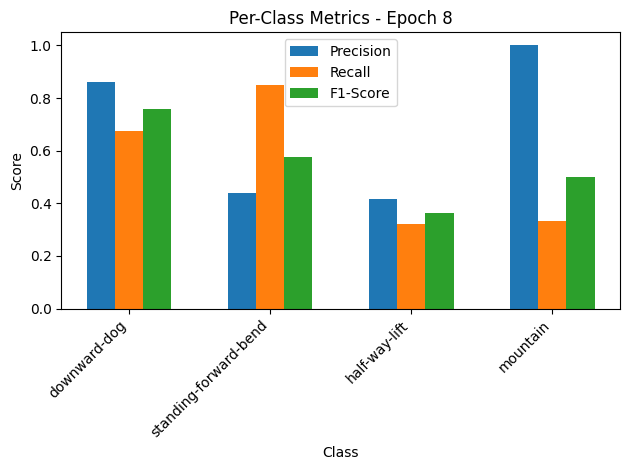


Epoch 9/50 Summary:
Train Loss: 1.4918 | Train Acc: 59.24% | Train Precision: 0.59 | Train Recall: 0.60 | Train F1: 0.60
Val Loss: 1.2507 | Val Acc: 56.80% | Val Precision: 0.68 | Val Recall: 0.55 | Val F1: 0.55

Epoch 10/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:19<00:00,  4.35s/it, loss=1.09, accuracy=64.1]


Per-Class Metrics for Epoch 9:
downward-dog: Precision=0.85, Recall=0.75, F1-Score=0.80
standing-forward-bend: Precision=0.52, Recall=0.52, F1-Score=0.52
half-way-lift: Precision=0.50, Recall=0.57, F1-Score=0.53
mountain: Precision=0.72, Recall=0.73, F1-Score=0.72


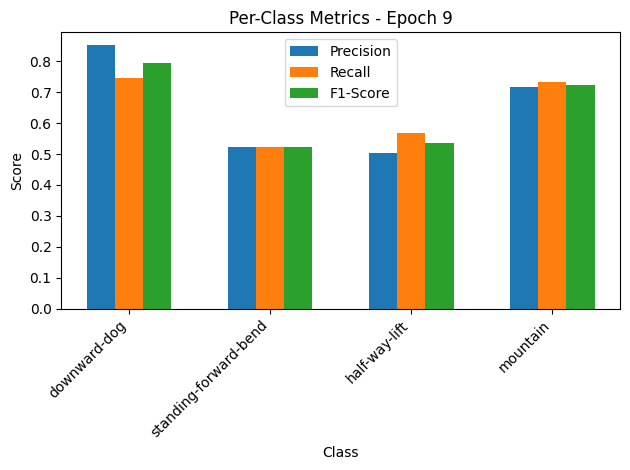

Validation: 100%|██████████| 8/8 [00:19<00:00,  2.45s/it, loss=1.49, accuracy=57.6]


Per-Class Metrics for Epoch 9:
downward-dog: Precision=1.00, Recall=0.62, F1-Score=0.77
standing-forward-bend: Precision=0.39, Recall=0.88, F1-Score=0.54
half-way-lift: Precision=0.50, Recall=0.23, F1-Score=0.31
mountain: Precision=0.93, Recall=0.54, F1-Score=0.68


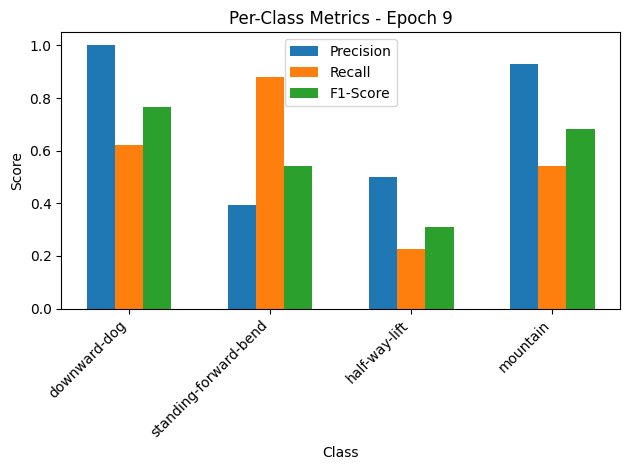


Epoch 10/50 Summary:
Train Loss: 1.1183 | Train Acc: 64.06% | Train Precision: 0.65 | Train Recall: 0.64 | Train F1: 0.64
Val Loss: 1.5246 | Val Acc: 57.60% | Val Precision: 0.71 | Val Recall: 0.57 | Val F1: 0.58

Epoch 11/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:25<00:00,  4.55s/it, loss=1.05, accuracy=66.7]


Per-Class Metrics for Epoch 10:
downward-dog: Precision=0.82, Recall=0.84, F1-Score=0.83
standing-forward-bend: Precision=0.55, Recall=0.58, F1-Score=0.57
half-way-lift: Precision=0.54, Recall=0.48, F1-Score=0.51
mountain: Precision=0.73, Recall=0.77, F1-Score=0.75


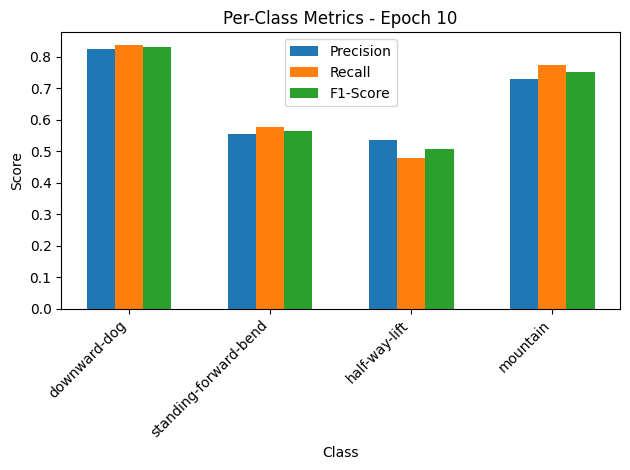

Validation: 100%|██████████| 8/8 [00:19<00:00,  2.38s/it, loss=0.727, accuracy=68]


Per-Class Metrics for Epoch 10:
downward-dog: Precision=1.00, Recall=0.65, F1-Score=0.79
standing-forward-bend: Precision=0.70, Recall=0.64, F1-Score=0.67
half-way-lift: Precision=0.47, Recall=0.81, F1-Score=0.60
mountain: Precision=0.83, Recall=0.62, F1-Score=0.71


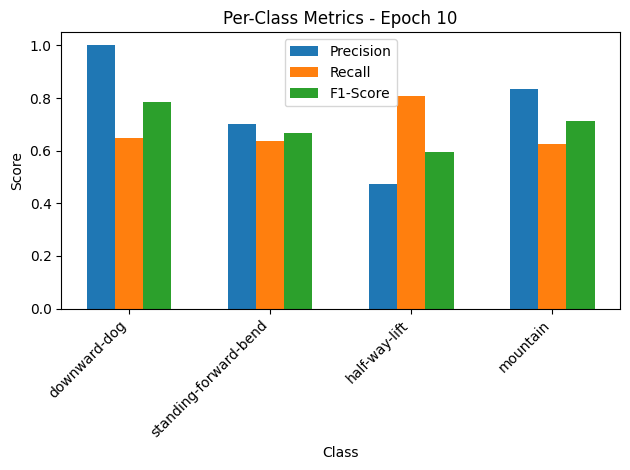


Epoch 11/50 Summary:
Train Loss: 1.0750 | Train Acc: 66.67% | Train Precision: 0.66 | Train Recall: 0.67 | Train F1: 0.66
Val Loss: 0.7447 | Val Acc: 68.00% | Val Precision: 0.75 | Val Recall: 0.68 | Val F1: 0.69
/content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model_fold_0.pth
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model.pth
Checkpoint saved at epoch 11
New best model saved! Validation Loss: 0.7447

Epoch 12/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:12<00:00,  4.15s/it, loss=1.06, accuracy=64.3]


Per-Class Metrics for Epoch 11:
downward-dog: Precision=0.88, Recall=0.73, F1-Score=0.79
standing-forward-bend: Precision=0.54, Recall=0.61, F1-Score=0.57
half-way-lift: Precision=0.53, Recall=0.52, F1-Score=0.52
mountain: Precision=0.66, Recall=0.71, F1-Score=0.68


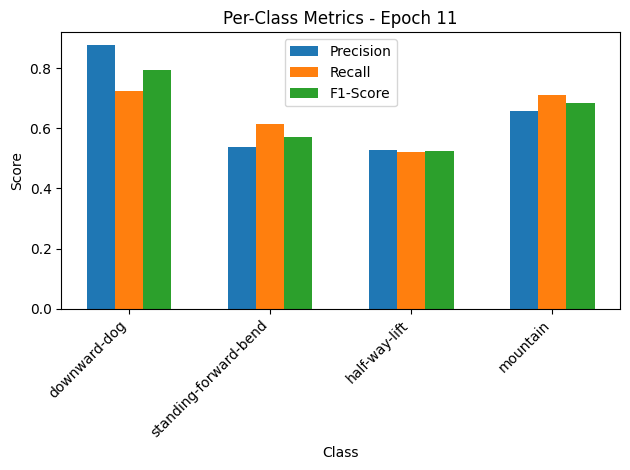

Validation: 100%|██████████| 8/8 [00:19<00:00,  2.45s/it, loss=0.844, accuracy=69.6]


Per-Class Metrics for Epoch 11:
downward-dog: Precision=0.73, Recall=0.86, F1-Score=0.79
standing-forward-bend: Precision=0.62, Recall=0.45, F1-Score=0.53
half-way-lift: Precision=0.57, Recall=0.68, F1-Score=0.62
mountain: Precision=0.95, Recall=0.79, F1-Score=0.86


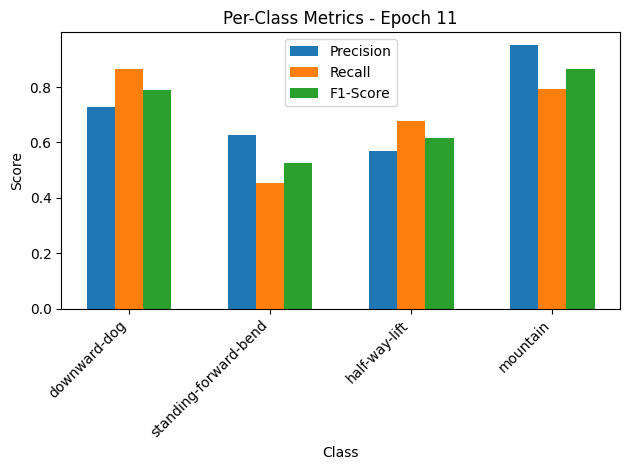


Epoch 12/50 Summary:
Train Loss: 1.0862 | Train Acc: 64.26% | Train Precision: 0.65 | Train Recall: 0.64 | Train F1: 0.64
Val Loss: 0.8642 | Val Acc: 69.60% | Val Precision: 0.72 | Val Recall: 0.70 | Val F1: 0.70

Epoch 13/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:11<00:00,  4.10s/it, loss=0.88, accuracy=64.1]


Per-Class Metrics for Epoch 12:
downward-dog: Precision=0.85, Recall=0.73, F1-Score=0.79
standing-forward-bend: Precision=0.49, Recall=0.42, F1-Score=0.45
half-way-lift: Precision=0.52, Recall=0.61, F1-Score=0.56
mountain: Precision=0.72, Recall=0.86, F1-Score=0.78


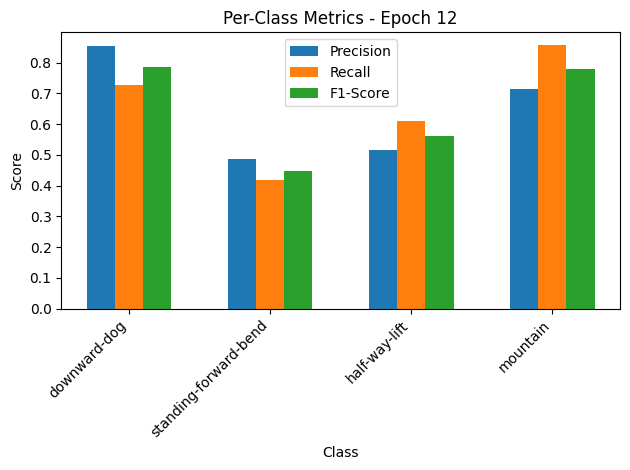

Validation: 100%|██████████| 8/8 [00:19<00:00,  2.38s/it, loss=1.38, accuracy=53.6]


Per-Class Metrics for Epoch 12:
downward-dog: Precision=0.96, Recall=0.59, F1-Score=0.73
standing-forward-bend: Precision=0.37, Recall=0.97, F1-Score=0.54
half-way-lift: Precision=0.80, Recall=0.39, F1-Score=0.52
mountain: Precision=1.00, Recall=0.04, F1-Score=0.08


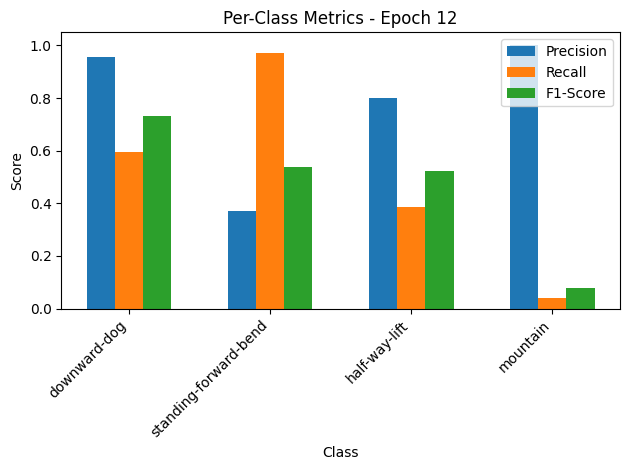


Epoch 13/50 Summary:
Train Loss: 0.9049 | Train Acc: 64.06% | Train Precision: 0.64 | Train Recall: 0.65 | Train F1: 0.64
Val Loss: 1.4137 | Val Acc: 53.60% | Val Precision: 0.78 | Val Recall: 0.50 | Val F1: 0.47

Epoch 14/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:12<00:00,  4.14s/it, loss=0.989, accuracy=66.3]


Per-Class Metrics for Epoch 13:
downward-dog: Precision=0.80, Recall=0.73, F1-Score=0.77
standing-forward-bend: Precision=0.54, Recall=0.62, F1-Score=0.58
half-way-lift: Precision=0.55, Recall=0.55, F1-Score=0.55
mountain: Precision=0.81, Recall=0.75, F1-Score=0.78


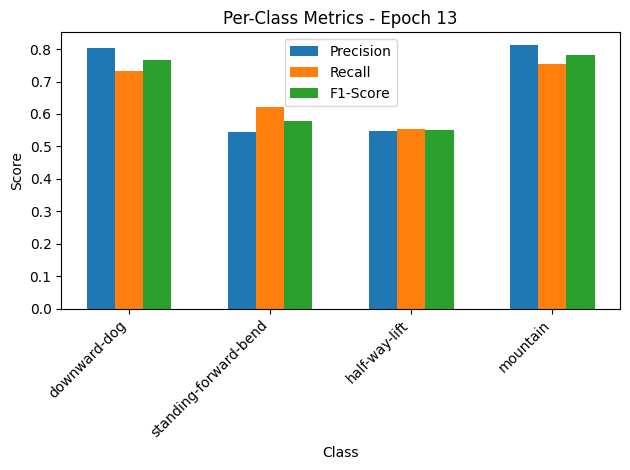

Validation: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it, loss=1.11, accuracy=45.6]


Per-Class Metrics for Epoch 13:
downward-dog: Precision=1.00, Recall=0.11, F1-Score=0.20
standing-forward-bend: Precision=0.80, Recall=0.12, F1-Score=0.21
half-way-lift: Precision=0.33, Recall=1.00, F1-Score=0.49
mountain: Precision=0.86, Recall=0.75, F1-Score=0.80


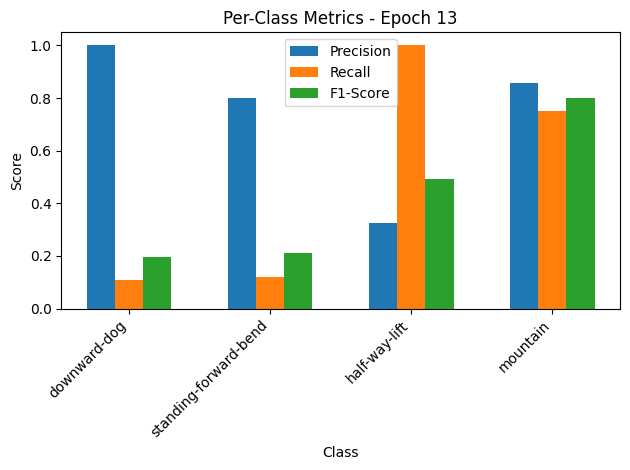


Epoch 14/50 Summary:
Train Loss: 1.0165 | Train Acc: 66.27% | Train Precision: 0.68 | Train Recall: 0.66 | Train F1: 0.67
Val Loss: 1.1387 | Val Acc: 45.60% | Val Precision: 0.75 | Val Recall: 0.49 | Val F1: 0.42

Epoch 15/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:12<00:00,  4.14s/it, loss=0.85, accuracy=68.5]


Per-Class Metrics for Epoch 14:
downward-dog: Precision=0.85, Recall=0.71, F1-Score=0.77
standing-forward-bend: Precision=0.61, Recall=0.75, F1-Score=0.67
half-way-lift: Precision=0.58, Recall=0.49, F1-Score=0.53
mountain: Precision=0.72, Recall=0.80, F1-Score=0.76


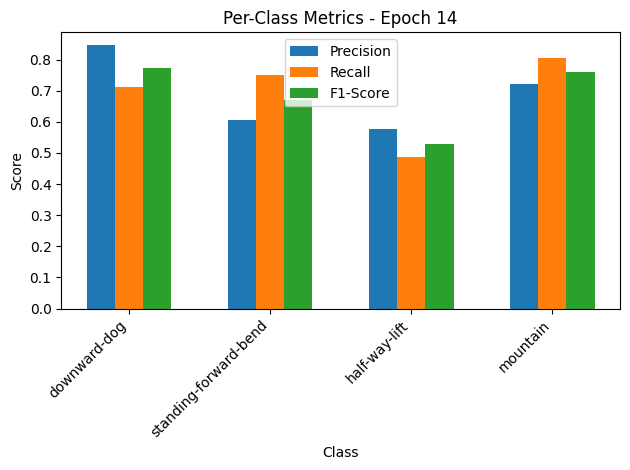

Validation: 100%|██████████| 8/8 [00:18<00:00,  2.36s/it, loss=0.923, accuracy=61.6]


Per-Class Metrics for Epoch 14:
downward-dog: Precision=1.00, Recall=0.65, F1-Score=0.79
standing-forward-bend: Precision=0.41, Recall=0.94, F1-Score=0.57
half-way-lift: Precision=0.79, Recall=0.35, F1-Score=0.49
mountain: Precision=0.92, Recall=0.46, F1-Score=0.61


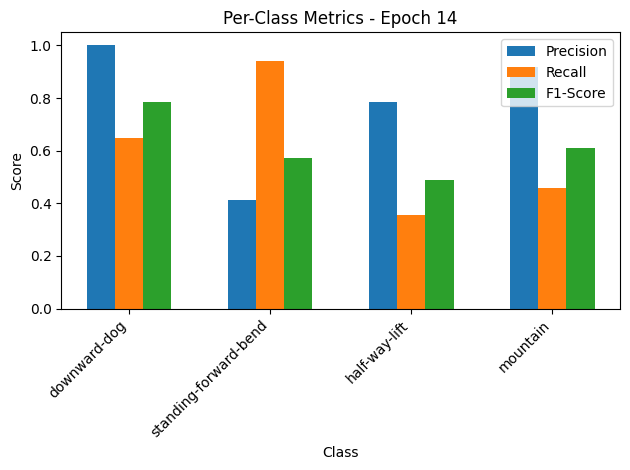


Epoch 15/50 Summary:
Train Loss: 0.8742 | Train Acc: 68.47% | Train Precision: 0.69 | Train Recall: 0.69 | Train F1: 0.68
Val Loss: 0.9453 | Val Acc: 61.60% | Val Precision: 0.78 | Val Recall: 0.60 | Val F1: 0.62

Epoch 16/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:11<00:00,  4.11s/it, loss=0.928, accuracy=70.3]


Per-Class Metrics for Epoch 15:
downward-dog: Precision=0.86, Recall=0.82, F1-Score=0.84
standing-forward-bend: Precision=0.62, Recall=0.66, F1-Score=0.64
half-way-lift: Precision=0.60, Recall=0.57, F1-Score=0.58
mountain: Precision=0.73, Recall=0.76, F1-Score=0.74


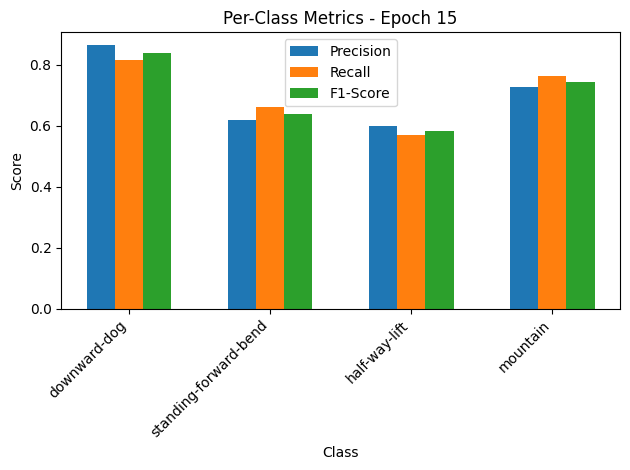

Validation: 100%|██████████| 8/8 [00:19<00:00,  2.40s/it, loss=1.25, accuracy=60.8]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Per-Class Metrics for Epoch 15:
downward-dog: Precision=0.93, Recall=0.76, F1-Score=0.84
standing-forward-bend: Precision=0.46, Recall=0.91, F1-Score=0.61
half-way-lift: Precision=0.60, Recall=0.58, F1-Score=0.59
mountain: Precision=0.00, Recall=0.00, F1-Score=0.00


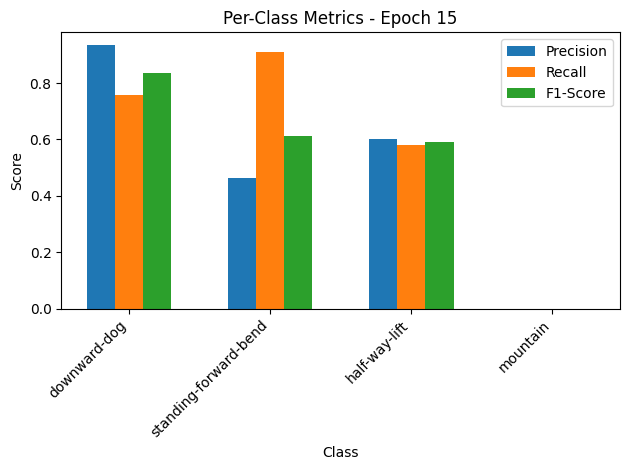


Epoch 16/50 Summary:
Train Loss: 0.9536 | Train Acc: 70.28% | Train Precision: 0.70 | Train Recall: 0.70 | Train F1: 0.70
Val Loss: 1.2752 | Val Acc: 60.80% | Val Precision: 0.50 | Val Recall: 0.56 | Val F1: 0.51

Epoch 17/50
Current Learning Rate: 0.001


Training: 100%|██████████| 32/32 [02:08<00:00,  4.01s/it, loss=0.89, accuracy=71.1]


Per-Class Metrics for Epoch 16:
downward-dog: Precision=0.86, Recall=0.79, F1-Score=0.83
standing-forward-bend: Precision=0.64, Recall=0.64, F1-Score=0.64
half-way-lift: Precision=0.69, Recall=0.63, F1-Score=0.66
mountain: Precision=0.64, Recall=0.79, F1-Score=0.71


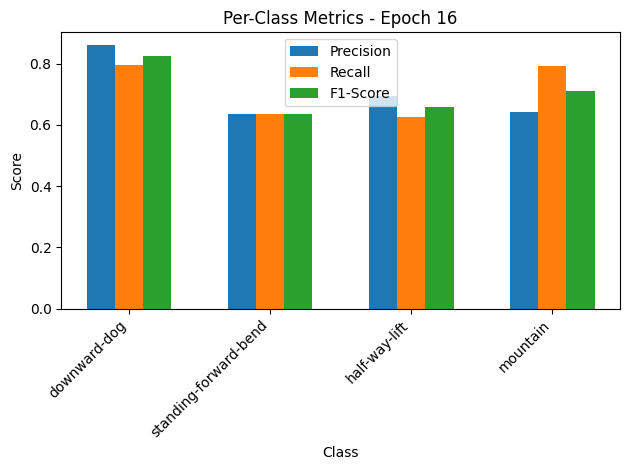

Validation: 100%|██████████| 8/8 [00:18<00:00,  2.36s/it, loss=1.52, accuracy=47.2]


Per-Class Metrics for Epoch 16:
downward-dog: Precision=1.00, Recall=0.22, F1-Score=0.36
standing-forward-bend: Precision=0.35, Recall=0.97, F1-Score=0.52
half-way-lift: Precision=0.54, Recall=0.23, F1-Score=0.32
mountain: Precision=0.92, Recall=0.50, F1-Score=0.65


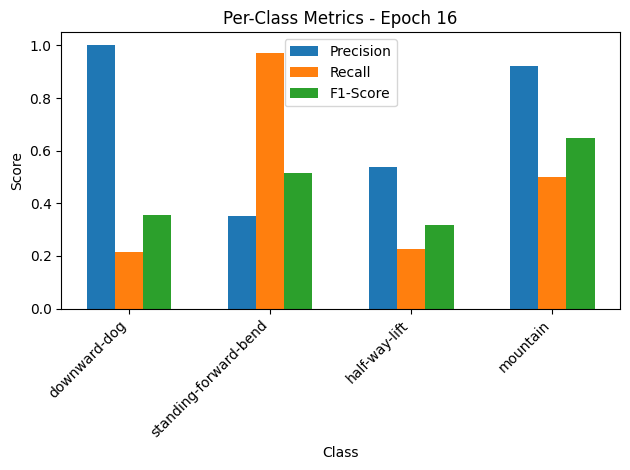


Epoch 17/50 Summary:
Train Loss: 0.9153 | Train Acc: 71.08% | Train Precision: 0.71 | Train Recall: 0.71 | Train F1: 0.71
Val Loss: 1.5606 | Val Acc: 47.20% | Val Precision: 0.70 | Val Recall: 0.48 | Val F1: 0.46

Epoch 18/50
Current Learning Rate: 0.0001


Training: 100%|██████████| 32/32 [02:10<00:00,  4.08s/it, loss=0.765, accuracy=70.7]


Per-Class Metrics for Epoch 17:
downward-dog: Precision=0.83, Recall=0.79, F1-Score=0.81
standing-forward-bend: Precision=0.66, Recall=0.67, F1-Score=0.66
half-way-lift: Precision=0.60, Recall=0.54, F1-Score=0.57
mountain: Precision=0.72, Recall=0.85, F1-Score=0.78


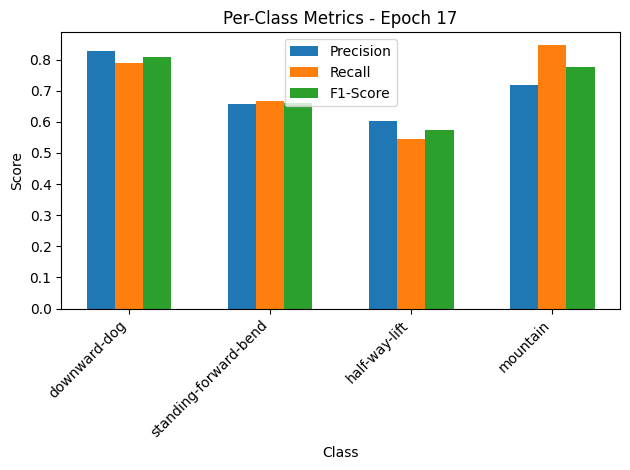

Validation: 100%|██████████| 8/8 [00:18<00:00,  2.35s/it, loss=0.526, accuracy=79.2]


Per-Class Metrics for Epoch 17:
downward-dog: Precision=0.83, Recall=0.92, F1-Score=0.87
standing-forward-bend: Precision=0.73, Recall=0.58, F1-Score=0.64
half-way-lift: Precision=0.68, Recall=0.74, F1-Score=0.71
mountain: Precision=0.96, Recall=0.96, F1-Score=0.96


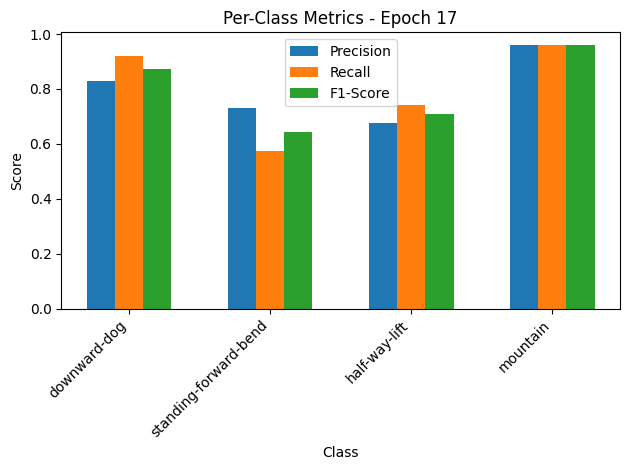


Epoch 18/50 Summary:
Train Loss: 0.7863 | Train Acc: 70.68% | Train Precision: 0.70 | Train Recall: 0.71 | Train F1: 0.70
Val Loss: 0.5389 | Val Acc: 79.20% | Val Precision: 0.80 | Val Recall: 0.80 | Val F1: 0.80
/content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model_fold_0.pth
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model.pth
Checkpoint saved at epoch 18
New best model saved! Validation Loss: 0.5389

Epoch 19/50
Current Learning Rate: 0.0001


Training: 100%|██████████| 32/32 [02:16<00:00,  4.27s/it, loss=0.558, accuracy=79.9]


Per-Class Metrics for Epoch 18:
downward-dog: Precision=0.86, Recall=0.86, F1-Score=0.86
standing-forward-bend: Precision=0.71, Recall=0.79, F1-Score=0.75
half-way-lift: Precision=0.78, Recall=0.66, F1-Score=0.71
mountain: Precision=0.86, Recall=0.91, F1-Score=0.88


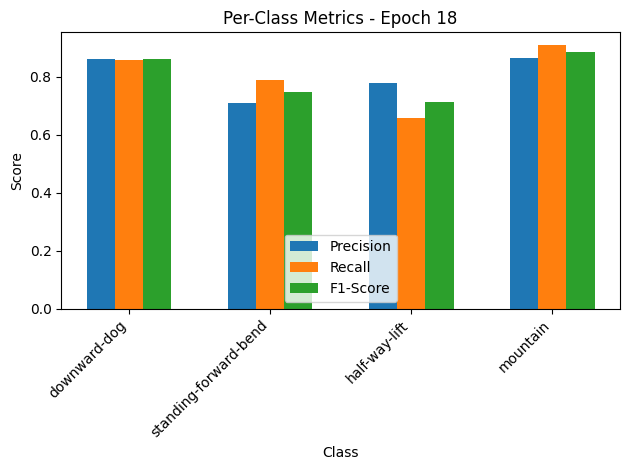

Validation: 100%|██████████| 8/8 [00:18<00:00,  2.35s/it, loss=0.475, accuracy=83.2]


Per-Class Metrics for Epoch 18:
downward-dog: Precision=0.95, Recall=0.95, F1-Score=0.95
standing-forward-bend: Precision=0.76, Recall=0.79, F1-Score=0.78
half-way-lift: Precision=0.80, Recall=0.65, F1-Score=0.71
mountain: Precision=0.79, Recall=0.96, F1-Score=0.87


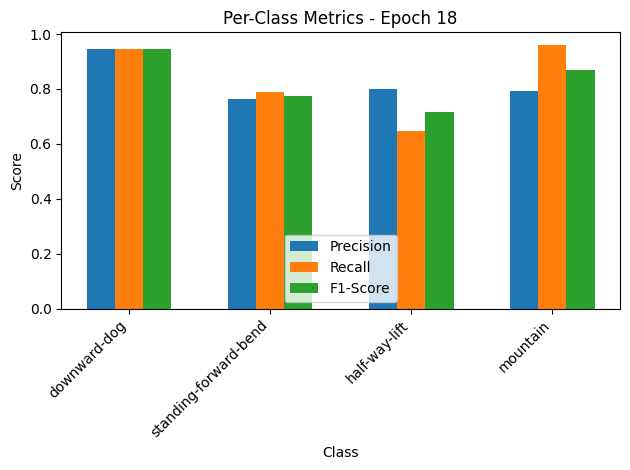


Epoch 19/50 Summary:
Train Loss: 0.5732 | Train Acc: 79.92% | Train Precision: 0.80 | Train Recall: 0.80 | Train F1: 0.80
Val Loss: 0.4863 | Val Acc: 83.20% | Val Precision: 0.83 | Val Recall: 0.83 | Val F1: 0.83
/content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model_fold_0.pth
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model.pth
Checkpoint saved at epoch 19
New best model saved! Validation Loss: 0.4863

Epoch 20/50
Current Learning Rate: 0.0001


Training: 100%|██████████| 32/32 [02:16<00:00,  4.28s/it, loss=0.52, accuracy=80.5]


Per-Class Metrics for Epoch 19:
downward-dog: Precision=0.91, Recall=0.86, F1-Score=0.89
standing-forward-bend: Precision=0.75, Recall=0.78, F1-Score=0.77
half-way-lift: Precision=0.74, Recall=0.69, F1-Score=0.71
mountain: Precision=0.81, Recall=0.90, F1-Score=0.85


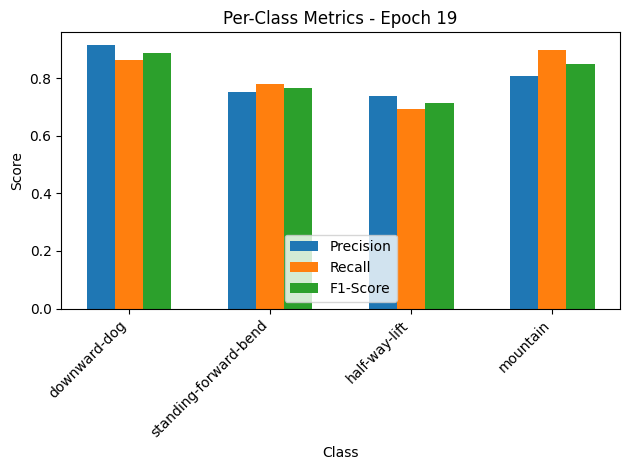

Validation: 100%|██████████| 8/8 [00:20<00:00,  2.57s/it, loss=0.453, accuracy=82.4]


Per-Class Metrics for Epoch 19:
downward-dog: Precision=0.97, Recall=0.89, F1-Score=0.93
standing-forward-bend: Precision=0.77, Recall=0.70, F1-Score=0.73
half-way-lift: Precision=0.77, Recall=0.77, F1-Score=0.77
mountain: Precision=0.77, Recall=0.96, F1-Score=0.85


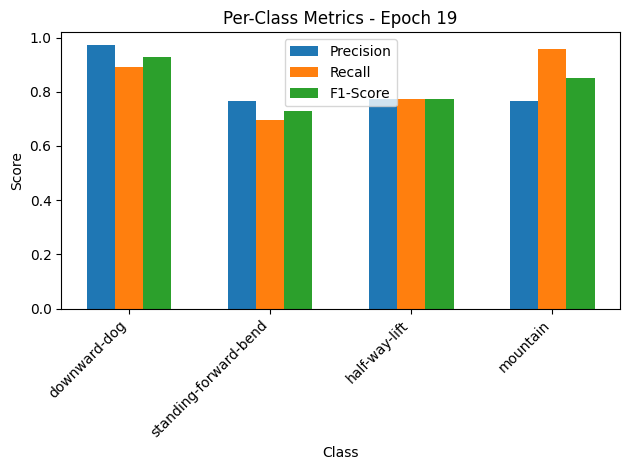


Epoch 20/50 Summary:
Train Loss: 0.5347 | Train Acc: 80.52% | Train Precision: 0.80 | Train Recall: 0.81 | Train F1: 0.80
Val Loss: 0.4640 | Val Acc: 82.40% | Val Precision: 0.82 | Val Recall: 0.83 | Val F1: 0.82
/content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model_fold_0.pth
Saving checkpoint to /content/gdrive/MyDrive/RGB_data_stream/CROSS_FOLD_2D_CNN_LSTM_2025-02-10_LR0.001_LHS512_LL1_CTResnet/best_model.pth
Checkpoint saved at epoch 20
New best model saved! Validation Loss: 0.4640

Epoch 21/50
Current Learning Rate: 0.0001


Training: 100%|██████████| 32/32 [02:19<00:00,  4.36s/it, loss=0.545, accuracy=82.1]


Per-Class Metrics for Epoch 20:
downward-dog: Precision=0.92, Recall=0.86, F1-Score=0.89
standing-forward-bend: Precision=0.74, Recall=0.82, F1-Score=0.78
half-way-lift: Precision=0.75, Recall=0.71, F1-Score=0.73
mountain: Precision=0.89, Recall=0.91, F1-Score=0.90


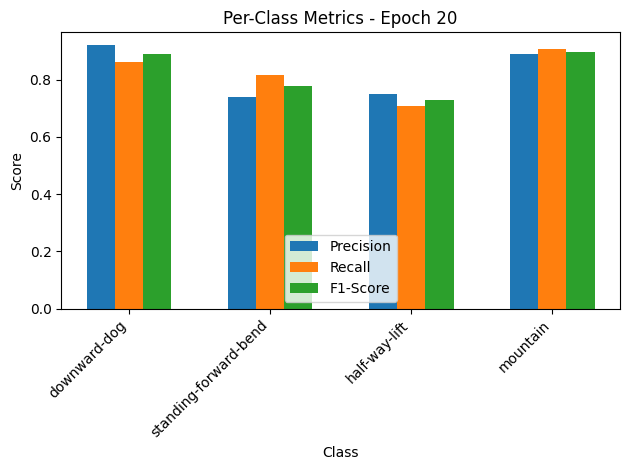

Validation: 100%|██████████| 8/8 [00:20<00:00,  2.61s/it, loss=0.532, accuracy=77.6]


Per-Class Metrics for Epoch 20:
downward-dog: Precision=1.00, Recall=0.78, F1-Score=0.88
standing-forward-bend: Precision=0.70, Recall=0.70, F1-Score=0.70
half-way-lift: Precision=0.68, Recall=0.74, F1-Score=0.71
mountain: Precision=0.76, Recall=0.92, F1-Score=0.83


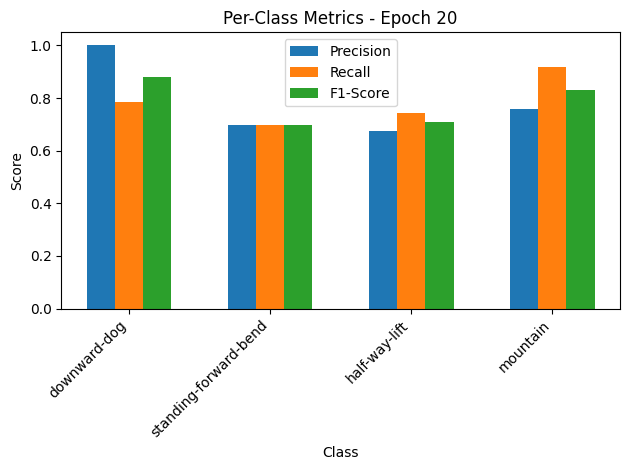


Epoch 21/50 Summary:
Train Loss: 0.5606 | Train Acc: 82.13% | Train Precision: 0.82 | Train Recall: 0.82 | Train F1: 0.82
Val Loss: 0.5451 | Val Acc: 77.60% | Val Precision: 0.78 | Val Recall: 0.78 | Val F1: 0.78

Epoch 22/50
Current Learning Rate: 0.0001


Training: 100%|██████████| 32/32 [02:24<00:00,  4.53s/it, loss=0.456, accuracy=84.1]


Per-Class Metrics for Epoch 21:
downward-dog: Precision=0.93, Recall=0.88, F1-Score=0.91
standing-forward-bend: Precision=0.76, Recall=0.83, F1-Score=0.79
half-way-lift: Precision=0.78, Recall=0.74, F1-Score=0.76
mountain: Precision=0.90, Recall=0.93, F1-Score=0.91


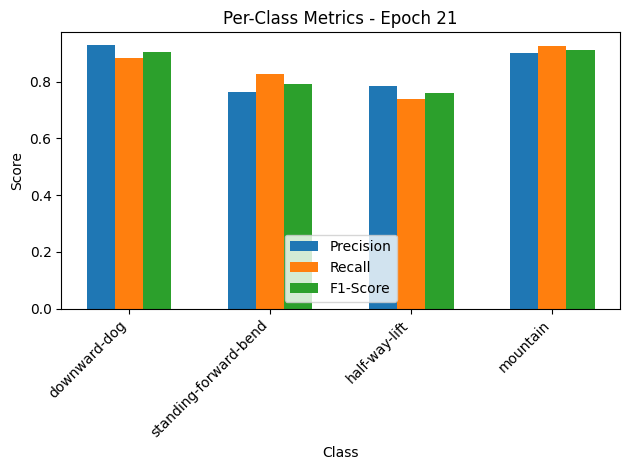

Validation: 100%|██████████| 8/8 [00:20<00:00,  2.58s/it, loss=0.462, accuracy=80]


Per-Class Metrics for Epoch 21:
downward-dog: Precision=0.97, Recall=0.89, F1-Score=0.93
standing-forward-bend: Precision=0.71, Recall=0.67, F1-Score=0.69
half-way-lift: Precision=0.67, Recall=0.77, F1-Score=0.72
mountain: Precision=0.88, Recall=0.88, F1-Score=0.88


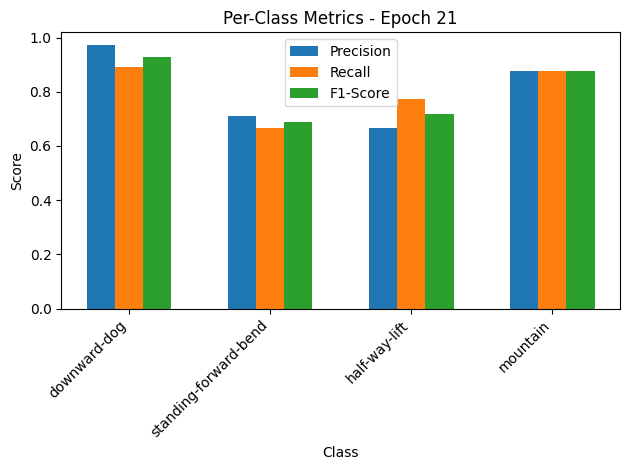


Epoch 22/50 Summary:
Train Loss: 0.4693 | Train Acc: 84.14% | Train Precision: 0.84 | Train Recall: 0.84 | Train F1: 0.84
Val Loss: 0.4731 | Val Acc: 80.00% | Val Precision: 0.81 | Val Recall: 0.80 | Val F1: 0.80

Epoch 23/50
Current Learning Rate: 0.0001


Training: 100%|██████████| 32/32 [02:22<00:00,  4.46s/it, loss=0.506, accuracy=82.9]


Per-Class Metrics for Epoch 22:
downward-dog: Precision=0.88, Recall=0.85, F1-Score=0.86
standing-forward-bend: Precision=0.80, Recall=0.88, F1-Score=0.84
half-way-lift: Precision=0.77, Recall=0.72, F1-Score=0.74
mountain: Precision=0.88, Recall=0.87, F1-Score=0.87


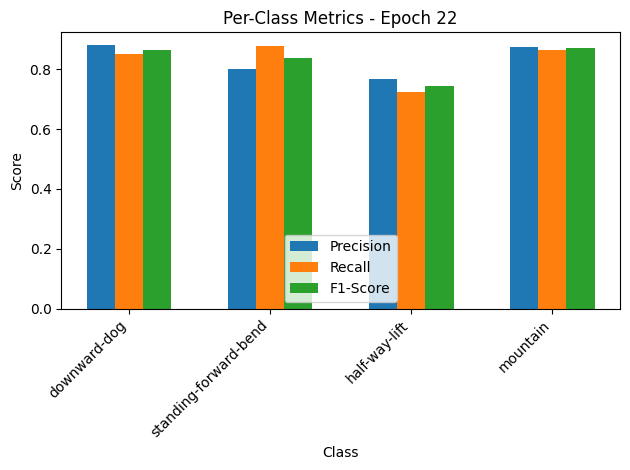

Validation: 100%|██████████| 8/8 [00:20<00:00,  2.59s/it, loss=0.514, accuracy=79.2]


Per-Class Metrics for Epoch 22:
downward-dog: Precision=0.90, Recall=0.95, F1-Score=0.92
standing-forward-bend: Precision=0.63, Recall=0.79, F1-Score=0.70
half-way-lift: Precision=0.77, Recall=0.55, F1-Score=0.64
mountain: Precision=0.91, Recall=0.88, F1-Score=0.89


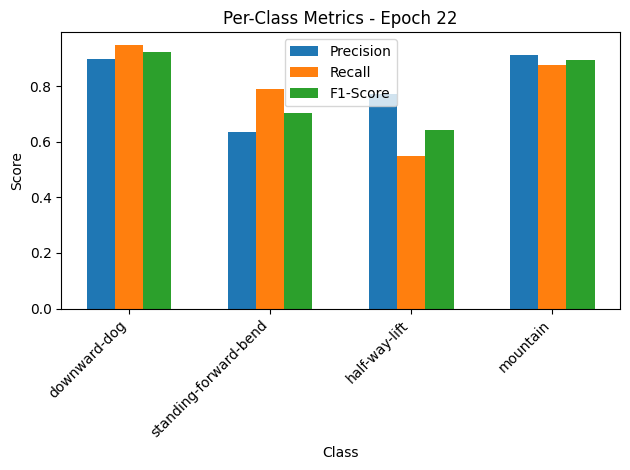


Epoch 23/50 Summary:
Train Loss: 0.5201 | Train Acc: 82.93% | Train Precision: 0.83 | Train Recall: 0.83 | Train F1: 0.83
Val Loss: 0.5260 | Val Acc: 79.20% | Val Precision: 0.80 | Val Recall: 0.79 | Val F1: 0.79

Epoch 24/50
Current Learning Rate: 0.0001


Training: 100%|██████████| 32/32 [02:30<00:00,  4.71s/it, loss=0.491, accuracy=83.1]


Per-Class Metrics for Epoch 23:
downward-dog: Precision=0.90, Recall=0.91, F1-Score=0.90
standing-forward-bend: Precision=0.78, Recall=0.81, F1-Score=0.80
half-way-lift: Precision=0.77, Recall=0.76, F1-Score=0.77
mountain: Precision=0.88, Recall=0.82, F1-Score=0.85


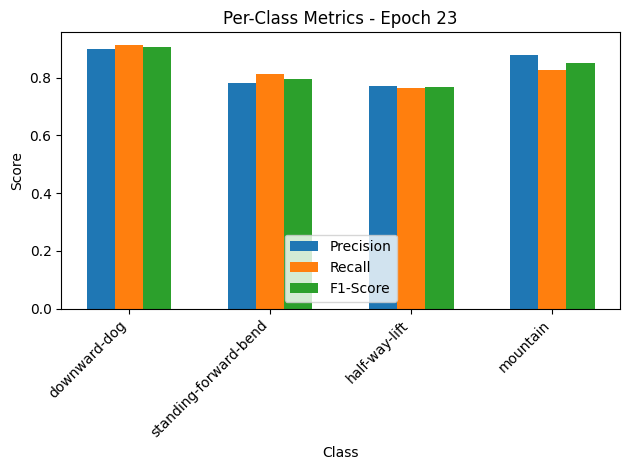

Validation: 100%|██████████| 8/8 [00:21<00:00,  2.69s/it, loss=0.51, accuracy=80.8]


Per-Class Metrics for Epoch 23:
downward-dog: Precision=0.92, Recall=0.92, F1-Score=0.92
standing-forward-bend: Precision=0.81, Recall=0.64, F1-Score=0.71
half-way-lift: Precision=0.62, Recall=0.84, F1-Score=0.71
mountain: Precision=1.00, Recall=0.83, F1-Score=0.91


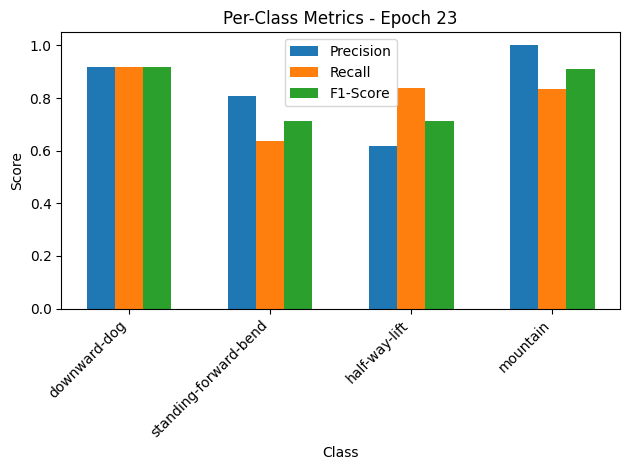


Epoch 24/50 Summary:
Train Loss: 0.5048 | Train Acc: 83.13% | Train Precision: 0.83 | Train Recall: 0.83 | Train F1: 0.83
Val Loss: 0.5227 | Val Acc: 80.80% | Val Precision: 0.84 | Val Recall: 0.81 | Val F1: 0.81

Epoch 25/50
Current Learning Rate: 0.0001


Training: 100%|██████████| 32/32 [02:31<00:00,  4.72s/it, loss=0.547, accuracy=81.7]


Per-Class Metrics for Epoch 24:
downward-dog: Precision=0.86, Recall=0.90, F1-Score=0.88
standing-forward-bend: Precision=0.80, Recall=0.76, F1-Score=0.78
half-way-lift: Precision=0.73, Recall=0.74, F1-Score=0.73
mountain: Precision=0.88, Recall=0.87, F1-Score=0.88


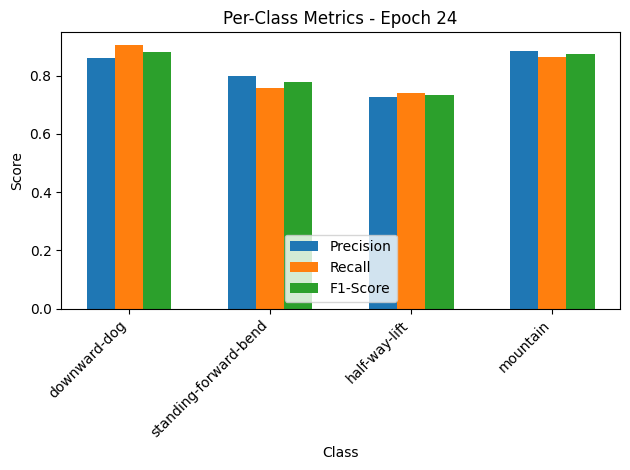

Validation: 100%|██████████| 8/8 [00:21<00:00,  2.67s/it, loss=0.654, accuracy=77.6]


Per-Class Metrics for Epoch 24:
downward-dog: Precision=0.77, Recall=1.00, F1-Score=0.87
standing-forward-bend: Precision=0.71, Recall=0.67, F1-Score=0.69
half-way-lift: Precision=0.70, Recall=0.61, F1-Score=0.66
mountain: Precision=1.00, Recall=0.79, F1-Score=0.88


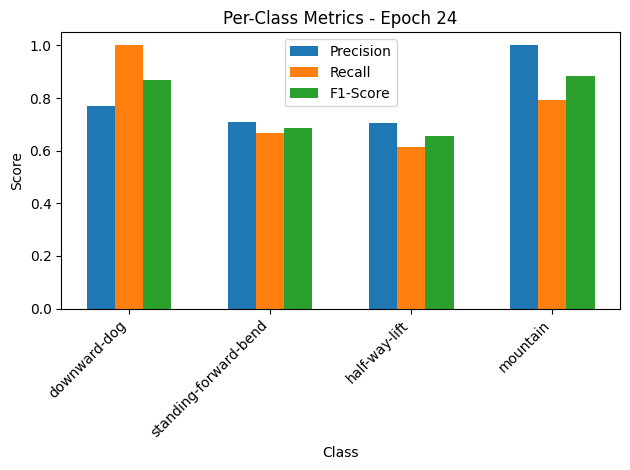


Epoch 25/50 Summary:
Train Loss: 0.5623 | Train Acc: 81.73% | Train Precision: 0.82 | Train Recall: 0.82 | Train F1: 0.82
Val Loss: 0.6693 | Val Acc: 77.60% | Val Precision: 0.80 | Val Recall: 0.77 | Val F1: 0.77

Epoch 26/50
Current Learning Rate: 0.0001


Training: 100%|██████████| 32/32 [02:25<00:00,  4.53s/it, loss=0.422, accuracy=85.7]


Per-Class Metrics for Epoch 25:
downward-dog: Precision=0.90, Recall=0.89, F1-Score=0.89
standing-forward-bend: Precision=0.84, Recall=0.83, F1-Score=0.83
half-way-lift: Precision=0.83, Recall=0.77, F1-Score=0.80
mountain: Precision=0.86, Recall=0.96, F1-Score=0.91


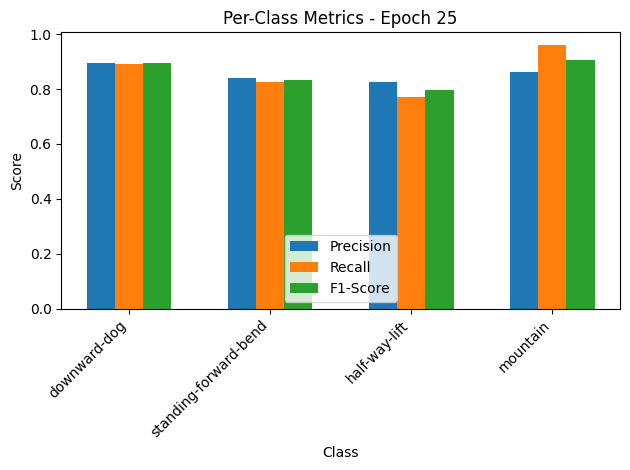

Validation: 100%|██████████| 8/8 [00:21<00:00,  2.70s/it, loss=0.589, accuracy=76.8]


Per-Class Metrics for Epoch 25:
downward-dog: Precision=0.92, Recall=0.92, F1-Score=0.92
standing-forward-bend: Precision=0.66, Recall=0.70, F1-Score=0.68
half-way-lift: Precision=0.72, Recall=0.58, F1-Score=0.64
mountain: Precision=0.75, Recall=0.88, F1-Score=0.81


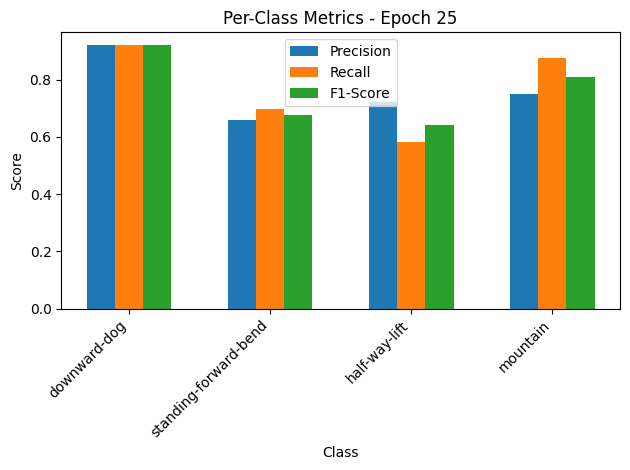


Epoch 26/50 Summary:
Train Loss: 0.4334 | Train Acc: 85.74% | Train Precision: 0.86 | Train Recall: 0.86 | Train F1: 0.86
Val Loss: 0.6029 | Val Acc: 76.80% | Val Precision: 0.76 | Val Recall: 0.77 | Val F1: 0.76

Epoch 27/50
Current Learning Rate: 1e-05


Training: 100%|██████████| 32/32 [02:24<00:00,  4.51s/it, loss=0.341, accuracy=88]


Per-Class Metrics for Epoch 26:
downward-dog: Precision=0.90, Recall=0.94, F1-Score=0.92
standing-forward-bend: Precision=0.83, Recall=0.88, F1-Score=0.85
half-way-lift: Precision=0.88, Recall=0.79, F1-Score=0.83
mountain: Precision=0.92, Recall=0.91, F1-Score=0.91


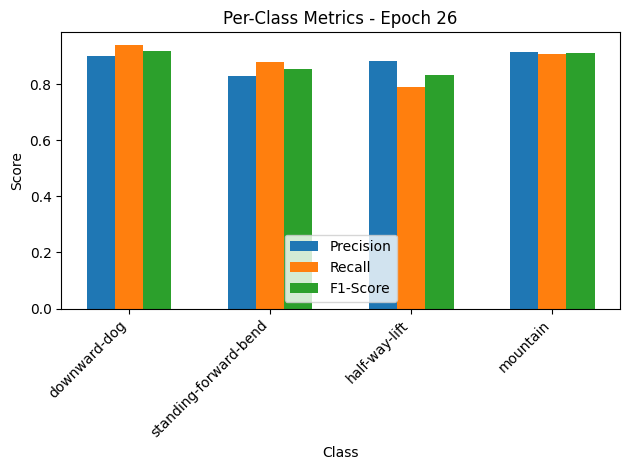

Validation: 100%|██████████| 8/8 [00:21<00:00,  2.67s/it, loss=0.526, accuracy=77.6]


Per-Class Metrics for Epoch 26:
downward-dog: Precision=0.87, Recall=0.89, F1-Score=0.88
standing-forward-bend: Precision=0.68, Recall=0.70, F1-Score=0.69
half-way-lift: Precision=0.69, Recall=0.65, F1-Score=0.67
mountain: Precision=0.88, Recall=0.88, F1-Score=0.88


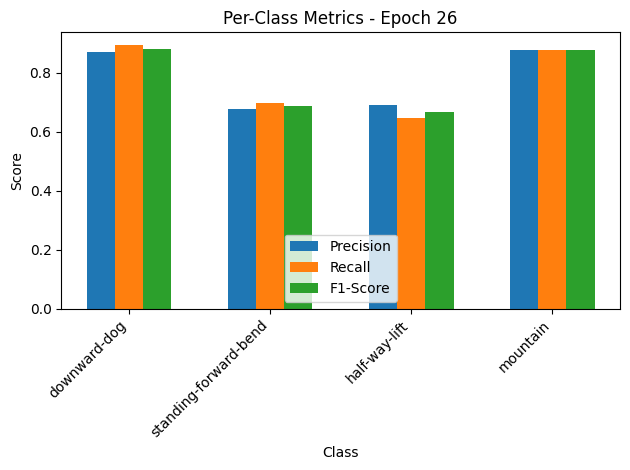


Epoch 27/50 Summary:
Train Loss: 0.3506 | Train Acc: 87.95% | Train Precision: 0.88 | Train Recall: 0.88 | Train F1: 0.88
Val Loss: 0.5391 | Val Acc: 77.60% | Val Precision: 0.78 | Val Recall: 0.78 | Val F1: 0.78

Epoch 28/50
Current Learning Rate: 1e-05


Training: 100%|██████████| 32/32 [02:21<00:00,  4.42s/it, loss=0.289, accuracy=90.2]


Per-Class Metrics for Epoch 27:
downward-dog: Precision=0.96, Recall=0.93, F1-Score=0.95
standing-forward-bend: Precision=0.85, Recall=0.87, F1-Score=0.86
half-way-lift: Precision=0.85, Recall=0.85, F1-Score=0.85
mountain: Precision=0.95, Recall=0.96, F1-Score=0.95


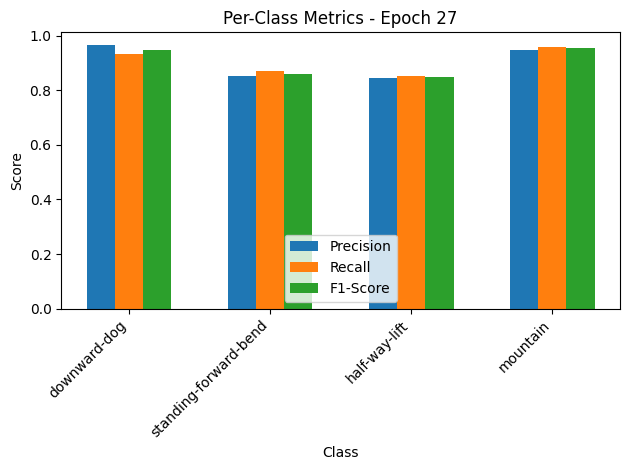

Validation: 100%|██████████| 8/8 [00:20<00:00,  2.59s/it, loss=0.599, accuracy=78.4]


Per-Class Metrics for Epoch 27:
downward-dog: Precision=0.91, Recall=0.86, F1-Score=0.89
standing-forward-bend: Precision=0.66, Recall=0.70, F1-Score=0.68
half-way-lift: Precision=0.67, Recall=0.71, F1-Score=0.69
mountain: Precision=0.95, Recall=0.88, F1-Score=0.91


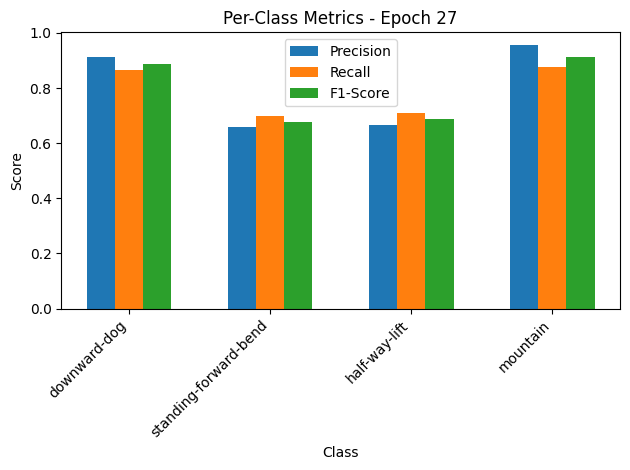


Epoch 28/50 Summary:
Train Loss: 0.2967 | Train Acc: 90.16% | Train Precision: 0.90 | Train Recall: 0.90 | Train F1: 0.90
Val Loss: 0.6134 | Val Acc: 78.40% | Val Precision: 0.80 | Val Recall: 0.79 | Val F1: 0.79

Epoch 29/50
Current Learning Rate: 1e-05


Training: 100%|██████████| 32/32 [02:24<00:00,  4.52s/it, loss=0.364, accuracy=88.8]


Per-Class Metrics for Epoch 28:
downward-dog: Precision=0.95, Recall=0.94, F1-Score=0.94
standing-forward-bend: Precision=0.86, Recall=0.85, F1-Score=0.85
half-way-lift: Precision=0.84, Recall=0.85, F1-Score=0.84
mountain: Precision=0.89, Recall=0.92, F1-Score=0.90


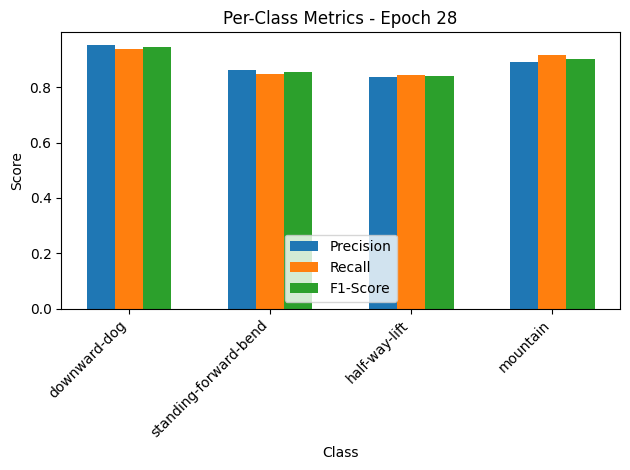

Validation: 100%|██████████| 8/8 [00:21<00:00,  2.69s/it, loss=0.619, accuracy=78.4]


Per-Class Metrics for Epoch 28:
downward-dog: Precision=0.85, Recall=0.92, F1-Score=0.88
standing-forward-bend: Precision=0.63, Recall=0.73, F1-Score=0.68
half-way-lift: Precision=0.73, Recall=0.61, F1-Score=0.67
mountain: Precision=1.00, Recall=0.88, F1-Score=0.93


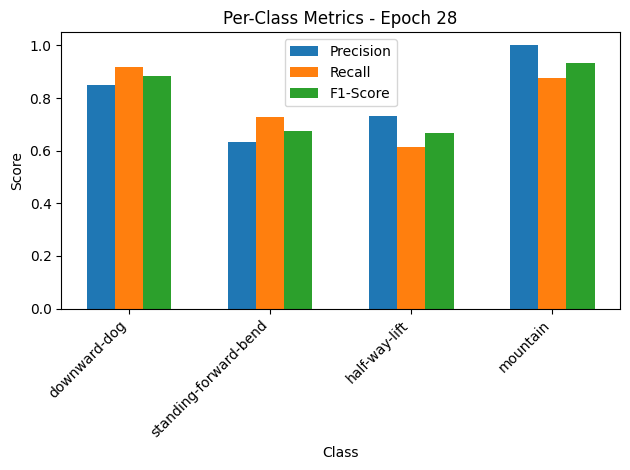


Epoch 29/50 Summary:
Train Loss: 0.3741 | Train Acc: 88.76% | Train Precision: 0.89 | Train Recall: 0.89 | Train F1: 0.89
Val Loss: 0.6342 | Val Acc: 78.40% | Val Precision: 0.80 | Val Recall: 0.78 | Val F1: 0.79

Epoch 30/50
Current Learning Rate: 1e-05


Training:  47%|████▋     | 15/32 [01:06<01:15,  4.46s/it, loss=0.38, accuracy=85.8]

In [ ]:
if __name__ == "__main__":
    main()

In [ ]:
# dataset, train_dataset, test_dataset = prepare_dataset()
# def create_data_loaders(train_dataset, test_dataset, batch_size = BATCH_SIZE):
#     train_loader = DataLoader(
#         train_dataset,
#         batch_size=batch_size,
#         shuffle=True,
#         num_workers=2,
#         pin_memory=True,
#         collate_fn=collate_fn
#     )

#     test_loader = DataLoader(
#         test_dataset,
#         batch_size=batch_size,
#         shuffle=False,
#         num_workers=2,
#         pin_memory=True,
#         collate_fn=collate_fn
#     )

#     return train_loader, test_loader
# train_loader, test_loader = create_data_loaders(train_dataset, test_dataset)

In [ ]:
# for batch in train_loader:
#     print(batch)  # See what is actually returned

#     break


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import numpy as np
import os
from tqdm import tqdm
import csv

def find_sus(model, test_loader, criterion, class_names, spath=SAVE_PATH, fsave='confusion_matrix_all.png'):
    """
    Evaluate model on test set

    Args:
        model: PyTorch model
        test_loader: DataLoader for test data
        criterion: Loss function
        class_names: List of class names
        save_path: Directory to save the plot
        fsave: Filename for confusion matrix plot
    """
    csave = os.path.join(spath, fsave)
    sussave = os.path.join(spath, 'sus.csv')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_predictions = []
    all_labels = []
    misclassified_data = []

    # Create progress bar
    test_loader_tqdm = tqdm(test_loader, desc="Testing")

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader_tqdm):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            # Calculate accuracy
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)

            # Store predictions and labels for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Check if the sample is misclassified
            misclassified_indices = (predicted != labels).nonzero(as_tuple=True)[0]
            for misclassified_idx in misclassified_indices:
                global_idx = batch_idx * inputs.size(0) + misclassified_idx.item()
                sequence_id = test_loader.dataset.idx_to_seq[global_idx]
                correct_label = class_names[labels[misclassified_idx].item()]
                prediction = class_names[predicted[misclassified_idx].item()]
                misclassified_data.append([sequence_id, correct_label, prediction])

    # Calculate metrics
    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * test_correct / test_total

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=pose_list, yticklabels=pose_list)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the plot
    plt.savefig(csave)
    plt.show()
    plt.close()

    # Save misclassified data to CSV
    with open(sussave, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['sequence_id', 'correct_label', 'prediction'])
        writer.writerows(misclassified_data)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.2f}%')

    return test_loss, accuracy

In [ ]:
dataset, train_dataset, test_dataset = prepare_dataset()
label_to_pose = {v:k for k,v in dataset.pose_to_label.items()}

model = CNNLSTM(num_classes=NUM_CLASSES, lstm_hidden_size=LSTM_HIDDEN_SIZE, lstm_layers=LSTM_LAYERS, dropout=DROPOUT)
# criterion = nn.CrossEntropyLoss()
all_labels = [dataset[i][1] for i in range(len(dataset))]
criterion = create_weighted_criterion(
        all_labels,
        num_classes= NUM_CLASSES,
        strategy='inverse'  # Try different strategies
    )
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint_path = os.path.join(SAVE_PATH, 'best_model.pth')
# Plot the training curves
if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(
            model, optimizer, checkpoint_path
        )
        print(f"Resuming training from epoch {start_epoch}")
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
# plot_training_curves(history)
find_sus(model, loader, criterion, label_to_pose)

In [ ]:
dataset, train_dataset, test_dataset = prepare_dataset()

model = CNNLSTM(num_classes=NUM_CLASSES, lstm_hidden_size=LSTM_HIDDEN_SIZE, lstm_layers=LSTM_LAYERS, dropout=DROPOUT)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint_path = os.path.join(SAVE_PATH, 'best_model.pth')
# Plot the training curves
if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, start_epoch, history = load_checkpoint(
            model, optimizer, checkpoint_path
        )
        print(f"Resuming training from epoch {start_epoch}")
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
evaluate_model(model, test_loader, criterion, pose_list)